# Introduction

Afin d'atteindre son objectif de ville neutre en émissions carbonnées en 2050, la ville de Seattle s'intéresse aux émissions des bâtiments non résidentiels.

Les agents municipaux ont donc effectué des relevés coûteux et minutieux en 2015 et 2016. À partir de ces relevés, je vais chercher à prédire les émissions de $CO_{2}$ et la consommation totale d'énergie des bâtiments pour lesquels les mesures n'ont pas encore été faites.

La prédiction se basera sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction, etc.)

De plus, l'**[ENERGY STAR Score](https://www.energystar.gov/buildings/benchmark/analyze_benchmarking_results)** étant fastidieux à calculer avec l'approche actuellement utilisée par les équipes, son intérêt pour la prédiction des émissions sera alors évalué.

Ce notebook a pour objectif de présenter l'analyse exploratoire des **[données](https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking#2015-building-energy-benchmarking.csv)**.

# Import des librairies et chargement des données

In [39]:
import os

# grammaire abstraite de l'arbre syntaxique de Python
import ast

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import is_string_dtype, is_numeric_dtype

pd.options.mode.chained_assignment = None  # default='warn'

Import des données de 2015

In [40]:
dossier_data = "data/"
nom_fichier = "2015-building-energy-benchmarking.csv"
batiments_2015_data = pd.read_csv(dossier_data+nom_fichier)

In [41]:
batiments_2015_data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,...,GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,...,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,...,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122...",7,DOWNTOWN,1969,...,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122...",7,DOWNTOWN,1926,...,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122....",7,DOWNTOWN,1980,...,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576


In [5]:
batiments_2015_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   OSEBuildingID                                                  3340 non-null   int64  
 1   DataYear                                                       3340 non-null   int64  
 2   BuildingType                                                   3340 non-null   object 
 3   PrimaryPropertyType                                            3340 non-null   object 
 4   PropertyName                                                   3340 non-null   object 
 5   TaxParcelIdentificationNumber                                  3338 non-null   object 
 6   Location                                                       3340 non-null   object 
 7   CouncilDistrictCode                                         

Import des données de 2016

In [42]:
dossier_data = "data/"
nom_fichier = "2016-building-energy-benchmarking.csv"
batiments_2016_data = pd.read_csv(dossier_data+nom_fichier)

In [43]:
batiments_2016_data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [44]:
batiments_2016_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

# Choix des variables

Pour rappel, je cherche à prédire les émissions de $CO_{2}$ (plus précisément les GES) et la consommation totale d'énergie des bâtiments non résidentiels et dont les mesures n'ont pas été effectuées. 

Les variables à prédire sont les suivantes :
- *GHGEmissions (2015)* et *TotalGHGEmissions (2016)* pour les émissions de GES
- *SiteEnergyUse(kBtu)* et *SiteEnergyUseWN(kBtu)* pour la consommation totale d'énergie, le choix devrait se porter sur la première variable car il s'agit de la consommation réelle

Note : *SiteEnergyUseWN(kBtu)* correspond à l'énergie annuelle consommée par le bâtiment ajustée à ce que le bâtiment aurait consommé pendant des conditions météorologiques moyennes de 30 ans. Je ne comprends pas tout à fait ce que cela signifie.

D'après cette **[source](https://www.statistiques.developpement-durable.gouv.fr/sites/default/files/2019-05/datalab-46-chiffres-cles-du-climat-edition-2019-novembre2018.pdf)**, l'énergie consommée par les bâtiments résidentiels est destinée aux usages suivants : chauffage, eau chaude sanitaire et la cuisson. Je vais donc me référer à ces usages pour les bâtiments non résidentiels en prenant en compte en plus les usages liés à l'activité réalisée dans le bâtiment. Par exemple, un café va utiliser de l'électricité pour faire du café ou d'autres boissons, de ce fait, le bâtiment consomme de l'électricité suite à l'activité de l'entreprise.

Les facteurs qui influencent la consommation d'énergie et les émissions de GES des bâtiments non-résidentiels sont les suivants : la taille du bâtiment, la façon dont le bâtiment et l'eau courante sont chauffés (gaz, électricité, fioul, etc.), l'isolation du bâtiment, le type de bâtiment (batîment individuel ou collectif), l'année de construction du bâtiment et l'activité du bâtiment (une boulangerie va consommer de l'électricité pour produire du pain). 

La localisation du bâtiment peut également jouer un rôle dans la consommation d'énergie. En effet, un quartier exposé à un vent froid régulièrement dans l'année verra ses bâtiments consommer plus d'énergie liée au chauffage.

Par conséquent, les variables conservées sont :
- *OSEBuildingID* : ID de la propriété
- *DataYear* : année du relevé pour différencier les données
- *BuildingType* : type de bâtiment selon la classification de Seattle
- *PrimaryPropertyType* : utilisation principale de la propriété (bureaux, université, etc.)
- *Location* : adresse complète de la propriété (uniquement pour 2015)
- *Address* : adresse postale (voie) de la propriété (uniquement pour 2016)
- *City* : ville où est située la propriété (uniquement pour 2016)
- *State* : état où est située la propriété (uniquement pour 2016)
- *ZipCode* : code postal de la propriété (uniquement pour 2016)
- *Neighborhood* : quartier où est située la propriété
- *YearBuilt* : année de construction ou de dernière rénovation complète de la propriété
- *NumberofBuildings* : nombre de bâtiments inclus dans la propriété
- *NumberofFloors* : nombre d'étages
- *PropertyGFABuilding(s)* : surface totale des bâtiments (en $ft^{2}$)
- *SecondLargestPropertyUseType* : utilisation secondaire de la propriété (utilisée pour analyser les données)
- *ENERGYSTARScore* : évalue la performance énergétique des bâtiments de la propriété, il permet de la comparer avec l'ensemble des bâtiments sur le territoire national US. Un score de 50 représente la médiane, un score plus élevé signifie qu'un bâtiment a de meilleures performances énergétiques que les autres (moins de consommation) et un score plus faible représente le contraire. Voir **[lien](https://www.energystar.gov/buildings/benchmark/analyze_benchmarking_results)** pour plus d'informations.
- *SiteEnergyUse(kBtu)* : énergie totale consommée par la propriété sur l'année reportée, en prenant en compte toutes les sources d'énergie
- *SteamUse(kBtu)* : énergie consommée par la propriété sur l'année reportée avec de la vapeur
- *Electricity(kBtu)* : énergie consommée par la propriété sur l'année reportée avec de l'électricité
- *NaturalGas(kBtu)* : énergie consommée par la propriété sur l'année reportée avec du gaz naturel
- *OtherFuelUse(kBtu)* : énergie consommée par la propriété sur l'année reportée avec d'autres combustibles (2015 seulement)
- *ComplianceStatus* : statut de la propriété si elle rencontre toutes les conformités du benchmarking réalisé l'année du relevé
- *Outlier* : définit si une propriété est un outlier (Y/N)
- *GHGEmissions(MetricTonsCO2e)* : émissions totales de GES relatives à la consommation énergétique de la propriété (en $t$ $CO_{2}$ $eq$, 2015 uniquement) 
- *TotalGHGEmissions* : émissions totales de GES relatives à la consommation énergétique de la propriété (en $t$ $CO_{2}$ $eq$, 2016 uniquement)

On observe les relations suivantes :
- *SiteEnergyUse(kBtu)* est la somme des variables *SteamUse(kBtu)*, *Electricity(kBtu)*, *NaturalGas(kBtu)* et *OtherFuelUse(kBtu)*
- *GHGEmissions(MetricTonsCO2e)* et *TotalGHGEmissions* sont le résultat d'une combinaison linéaire des mêmes variables citées ci-avant

Notes : 
- le choix de retenir *SourceEUI* a été envisagé car l'*ENERGYSTARScore* utilise cette variable dans ses calculs. Cependant, étant donné les relations décrites ci-dessus, elle ne sera pas retenue.
- l'*ENERGYSTARScore* est calculé grâce à la taille du bâtiment, sa localisation, son nombre d'occupants, son nombre de PC et les données énergétiques relevées.

Attention à bien utiliser les variables relatives aux données déclaratives du permis d'exploitation commerciale et pas les autres.


In [45]:
variables_conservees = ['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType', 'Neighborhood', 
                        'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFABuilding(s)', 
                        'SecondLargestPropertyUseType', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 
                        'Electricity(kBtu)', 'NaturalGas(kBtu)', 'ComplianceStatus', 'Outlier']

variables_specifiques_2015 = ['Location', 'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)']
variables_specifiques_2016 = ['Address', 'City', 'State', 'ZipCode', 'TotalGHGEmissions']

variables_conservees_2015 = variables_conservees + variables_specifiques_2015
variables_conservees_2016 = variables_conservees + variables_specifiques_2016

In [46]:
batiments_2015_data = batiments_2015_data[variables_conservees_2015]
batiments_2016_data = batiments_2016_data[variables_conservees_2016]

In [47]:
batiments_2015_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   OSEBuildingID                 3340 non-null   int64  
 1   DataYear                      3340 non-null   int64  
 2   BuildingType                  3340 non-null   object 
 3   PrimaryPropertyType           3340 non-null   object 
 4   Neighborhood                  3340 non-null   object 
 5   YearBuilt                     3340 non-null   int64  
 6   NumberofBuildings             3340 non-null   int64  
 7   NumberofFloors                3332 non-null   float64
 8   PropertyGFABuilding(s)        3340 non-null   int64  
 9   SecondLargestPropertyUseType  1559 non-null   object 
 10  ENERGYSTARScore               2560 non-null   float64
 11  SiteEnergyUse(kBtu)           3330 non-null   float64
 12  SteamUse(kBtu)                3330 non-null   float64
 13  Ele

In [48]:
batiments_2016_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   OSEBuildingID                 3376 non-null   int64  
 1   DataYear                      3376 non-null   int64  
 2   BuildingType                  3376 non-null   object 
 3   PrimaryPropertyType           3376 non-null   object 
 4   Neighborhood                  3376 non-null   object 
 5   YearBuilt                     3376 non-null   int64  
 6   NumberofBuildings             3368 non-null   float64
 7   NumberofFloors                3376 non-null   int64  
 8   PropertyGFABuilding(s)        3376 non-null   int64  
 9   SecondLargestPropertyUseType  1679 non-null   object 
 10  ENERGYSTARScore               2533 non-null   float64
 11  SiteEnergyUse(kBtu)           3371 non-null   float64
 12  SteamUse(kBtu)                3367 non-null   float64
 13  Ele

# Concaténation des deux jeux de données

Préparation des données de 2015 pour les concaténer avec celles de 2016 :
- création des variables *Address*, *City*, *State* et *ZipCode* avec *Location*
- suppression de *Location* et des variables intermédiaires
- renommage de *GHGEmissions(MetricTonsCO2e)* en *GHGEmissions*

In [49]:
# conversion d'un string en dictionnaire
def convertir_string_en_dict(string):
    return ast.literal_eval(string)

In [50]:
# création des nouvelles variables
nb_lignes = len(batiments_2015_data)
batiments_2015_data['Location_dict'] = [convertir_string_en_dict(batiments_2015_data.Location[i]) for i in range(nb_lignes)]
batiments_2015_data['human_address'] = [convertir_string_en_dict(batiments_2015_data.Location_dict[i]['human_address']) 
                                            for i in range(nb_lignes)]
batiments_2015_data['Address'] = [batiments_2015_data['human_address'][i]['address'] for i in range(nb_lignes)]
batiments_2015_data['City'] = [batiments_2015_data['human_address'][i]['city'] for i in range(nb_lignes)]
batiments_2015_data['State'] = [batiments_2015_data['human_address'][i]['state'] for i in range(nb_lignes)]
batiments_2015_data['ZipCode'] = [batiments_2015_data['human_address'][i]['zip'] for i in range(nb_lignes)]

In [51]:
# suppression des variables intermédiaires
batiments_2015_data.drop(columns=['Location', 'Location_dict', 'human_address'], inplace=True)

In [52]:
# renommage de la variable GHGEmissions(MetricTonsCO2e)
batiments_2015_data.rename(columns = {'GHGEmissions(MetricTonsCO2e)':'GHGEmissions'}, inplace=True)

In [53]:
batiments_2015_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   OSEBuildingID                 3340 non-null   int64  
 1   DataYear                      3340 non-null   int64  
 2   BuildingType                  3340 non-null   object 
 3   PrimaryPropertyType           3340 non-null   object 
 4   Neighborhood                  3340 non-null   object 
 5   YearBuilt                     3340 non-null   int64  
 6   NumberofBuildings             3340 non-null   int64  
 7   NumberofFloors                3332 non-null   float64
 8   PropertyGFABuilding(s)        3340 non-null   int64  
 9   SecondLargestPropertyUseType  1559 non-null   object 
 10  ENERGYSTARScore               2560 non-null   float64
 11  SiteEnergyUse(kBtu)           3330 non-null   float64
 12  SteamUse(kBtu)                3330 non-null   float64
 13  Ele

Préparation des données de 2016 pour les concaténer avec celles de 2015 :
- création de la variable *OtherFuelUse(kBtu)*
- remplissage de cette variable avec des 0
- renommage de TotalGHGEmissions en GHGEmissions

In [54]:
# création de la variable OtherFuelUse(kBtu) et remplissage avec des 0
batiments_2016_data['OtherFuelUse(kBtu)'] = 0

In [55]:
# renommage de la variable TotalGHGEmissions
batiments_2016_data.rename(columns = {'TotalGHGEmissions':'GHGEmissions'}, inplace=True)

In [56]:
batiments_2016_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   OSEBuildingID                 3376 non-null   int64  
 1   DataYear                      3376 non-null   int64  
 2   BuildingType                  3376 non-null   object 
 3   PrimaryPropertyType           3376 non-null   object 
 4   Neighborhood                  3376 non-null   object 
 5   YearBuilt                     3376 non-null   int64  
 6   NumberofBuildings             3368 non-null   float64
 7   NumberofFloors                3376 non-null   int64  
 8   PropertyGFABuilding(s)        3376 non-null   int64  
 9   SecondLargestPropertyUseType  1679 non-null   object 
 10  ENERGYSTARScore               2533 non-null   float64
 11  SiteEnergyUse(kBtu)           3371 non-null   float64
 12  SteamUse(kBtu)                3367 non-null   float64
 13  Ele

Concaténation des deux datasets et renommage des colonnes ayant des parenthèses.

In [184]:
batiments_data = pd.concat([batiments_2015_data, batiments_2016_data])
batiments_data.rename(columns = {'PropertyGFABuilding(s)':'PropertyGFABuilding',
                                 'SiteEnergyUse(kBtu)':'SiteEnergyUse',
                                 'SteamUse(kBtu)':'SteamUse',
                                 'Electricity(kBtu)':'Electricity',
                                 'NaturalGas(kBtu)':'NaturalGas',
                                 'OtherFuelUse(kBtu)':'OtherFuelUse'}, inplace=True)
batiments_data.reset_index(drop=True, inplace=True)

In [185]:
batiments_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6716 entries, 0 to 6715
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   OSEBuildingID                 6716 non-null   int64  
 1   DataYear                      6716 non-null   int64  
 2   BuildingType                  6716 non-null   object 
 3   PrimaryPropertyType           6716 non-null   object 
 4   Neighborhood                  6716 non-null   object 
 5   YearBuilt                     6716 non-null   int64  
 6   NumberofBuildings             6708 non-null   float64
 7   NumberofFloors                6708 non-null   float64
 8   PropertyGFABuilding           6716 non-null   int64  
 9   SecondLargestPropertyUseType  3238 non-null   object 
 10  ENERGYSTARScore               5093 non-null   float64
 11  SiteEnergyUse                 6701 non-null   float64
 12  SteamUse                      6697 non-null   float64
 13  Ele

# Vérifications sur le dataset

## Doublons parmi les modalités de variables

### Utilisation principale du bâtiment

In [186]:
batiments_data["PrimaryPropertyType"].value_counts()

Low-Rise Multifamily           1985
Mid-Rise Multifamily           1103
Small- and Mid-Sized Office     590
Other                           514
Large Office                    344
K-12 School                     275
Mixed Use Property              259
High-Rise Multifamily           208
Retail Store                    191
Non-Refrigerated Warehouse      187
Warehouse                       187
Hotel                           150
Worship Facility                143
Senior Care Community            88
Medical Office                   82
Distribution Center              55
Distribution Center\r\n          51
Supermarket / Grocery Store      40
Supermarket/Grocery Store        36
Self-Storage Facility            29
Self-Storage Facility\r\n        27
University                       25
Refrigerated Warehouse           25
Residence Hall                   23
College/University               22
Hospital                         20
Residence Hall/Dormitory         15
Restaurant                  

In [187]:
# Utilisation principale de la propriété : remplacements
batiments_data.loc[batiments_data.PrimaryPropertyType == "Restaurant\r\n", "PrimaryPropertyType"] = "Restaurant"
batiments_data.loc[batiments_data.PrimaryPropertyType == "Distribution Center\r\n", "PrimaryPropertyType"] = "Distribution Center"
batiments_data.loc[batiments_data.PrimaryPropertyType == "Supermarket / Grocery Store", 
                   "PrimaryPropertyType"] = "Supermarket/Grocery Store"
batiments_data.loc[batiments_data.PrimaryPropertyType == "Self-Storage Facility\r\n", 
                   "PrimaryPropertyType"] = "Self-Storage Facility"
batiments_data.loc[batiments_data.PrimaryPropertyType == "College/University", "PrimaryPropertyType"] = "University"
batiments_data.loc[batiments_data.PrimaryPropertyType == "Residence Hall/Dormitory", "PrimaryPropertyType"] = "Residence Hall"
batiments_data.loc[batiments_data.PrimaryPropertyType == "SPS-District K-12", "PrimaryPropertyType"] = "K-12 School"

In [188]:
batiments_data["PrimaryPropertyType"].value_counts()

Low-Rise Multifamily           1985
Mid-Rise Multifamily           1103
Small- and Mid-Sized Office     590
Other                           514
Large Office                    344
K-12 School                     279
Mixed Use Property              259
High-Rise Multifamily           208
Retail Store                    191
Non-Refrigerated Warehouse      187
Warehouse                       187
Hotel                           150
Worship Facility                143
Distribution Center             106
Senior Care Community            88
Medical Office                   82
Supermarket/Grocery Store        76
Self-Storage Facility            56
University                       47
Residence Hall                   38
Refrigerated Warehouse           25
Restaurant                       24
Hospital                         20
Laboratory                       11
Office                            3
Name: PrimaryPropertyType, dtype: int64

### Quartier

In [189]:
batiments_data["Neighborhood"].value_counts()

DOWNTOWN                  1151
EAST                       897
MAGNOLIA / QUEEN ANNE      843
GREATER DUWAMISH           744
NORTHEAST                  539
LAKE UNION                 500
NORTHWEST                  436
NORTH                      333
SOUTHWEST                  331
BALLARD                    256
CENTRAL                    238
SOUTHEAST                  191
DELRIDGE                   165
North                       42
Central                     27
Northwest                   11
Ballard                      7
Delridge                     4
DELRIDGE NEIGHBORHOODS       1
Name: Neighborhood, dtype: int64

In [190]:
# Quartier : remplacement
batiments_data.loc[batiments_data.Neighborhood == "North", "Neighborhood"] = "NORTH"
batiments_data.loc[batiments_data.Neighborhood == "Ballard", "Neighborhood"] = "BALLARD"
batiments_data.loc[batiments_data.Neighborhood == "Central", "Neighborhood"] = "CENTRAL"
batiments_data.loc[batiments_data.Neighborhood == "Northwest", "Neighborhood"] = "NORTHWEST"
batiments_data.loc[batiments_data.Neighborhood == "Delridge", "Neighborhood"] = "DELRIDGE"
batiments_data.loc[batiments_data.Neighborhood == "DELRIDGE NEIGHBORHOODS", "Neighborhood"] = "DELRIDGE"

In [191]:
batiments_data["Neighborhood"].value_counts()

DOWNTOWN                 1151
EAST                      897
MAGNOLIA / QUEEN ANNE     843
GREATER DUWAMISH          744
NORTHEAST                 539
LAKE UNION                500
NORTHWEST                 447
NORTH                     375
SOUTHWEST                 331
CENTRAL                   265
BALLARD                   263
SOUTHEAST                 191
DELRIDGE                  170
Name: Neighborhood, dtype: int64

### Outlier

In [192]:
batiments_data["Outlier"].value_counts()

High Outlier    46
Low Outlier     38
Low outlier     23
High outlier     9
Name: Outlier, dtype: int64

In [193]:
# Outlier : remplacements
batiments_data.loc[batiments_data.Outlier == "Low outlier", "Outlier"] = "Low Outlier"
batiments_data.loc[batiments_data.Outlier == "High outlier", "Outlier"] = "High Outlier"

In [194]:
batiments_data["Outlier"].value_counts()

Low Outlier     61
High Outlier    55
Name: Outlier, dtype: int64

## Vérifications sur le type des bâtiments

L'enjeu de cette partie est de vérifier que tous les bâtiments sont bien non-résidentiels car je cherche à prédire la consommation énergétique de ces bâtiments.

<AxesSubplot:xlabel='count', ylabel='BuildingType'>

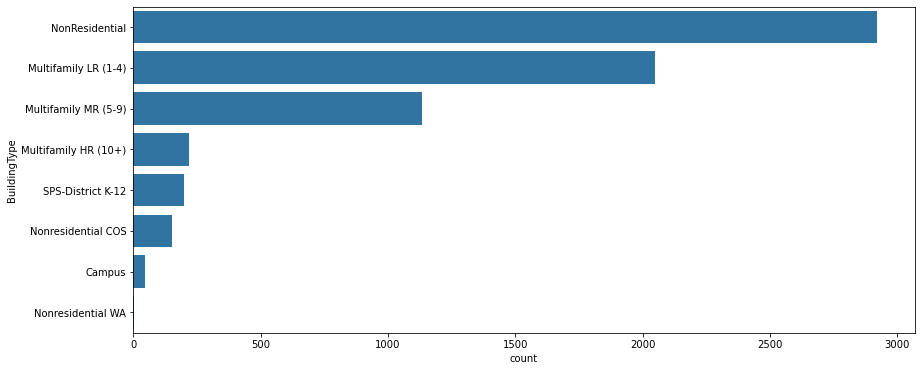

In [164]:
plt.rcParams["figure.figsize"] = (14, 6)
sns.countplot(y="BuildingType", color='tab:blue', data=batiments_data, order=batiments_data.BuildingType.value_counts().index)

In [18]:
batiments_data[batiments_data["BuildingType"] == "Campus"][["BuildingType", 
                                                            "PrimaryPropertyType", 
                                                            "SecondLargestPropertyUseType"]]

,BuildingType,PrimaryPropertyType,SecondLargestPropertyUseType
105,Campus,College/University,NaN
127,Campus,College/University,NaN
161,Campus,Large Office,Laboratory
195,Campus,Other,NaN
290,Campus,Mixed Use Property,Other - Restaurant/Bar
302,Campus,Mixed Use Property,Office
341,Campus,Other,Parking
665,Campus,Other,NaN
967,Campus,K-12 School,NaN
1308,Campus,Mixed Use Property,Restaurant


Le dataset contient plusieurs types de propriétés :
- les *Multifamily LR, MR et HR* sont des bâtiments résidentiels où plusieurs familles vivent dans le même bâtiment, il peut s'agir de logements collectifs, de maisons mitoyennes ou d'appartements. Ces bâtiments ne m'intéressent pas, ils seront écartés de l'étude.
- les *NonResidential (COS & WA)* représentent les bâtiments non résidentiels. Ce sont ceux qui m'intéressent.
- les *SPS-District K-12* sont les écoles publiques de Seattle, ce sont des bâtiments non résidentiels également. Je les conserve donc dans l'étude.
- et les *Campus* regroupent des universités, des écoles ou des propriétés à utilisation mixte (restaurant et habitation par exemple), ils seront conservés car les propriétés ayant un usage principal de type résidentiel (*Mixed Use Property* ou *Low-Rise Multifamily*), leur usage secondaire concernent un usage non-résidentiel et je pense que cela a plus de poids dans la consommation d'énergie.

Vérifions l'utilisation primaire des bâtiments pour chaque type d'entre eux pour vérifier si cela est cohérent.

In [68]:
batiments_data["BuildingType"].value_counts()

NonResidential          2921
Multifamily LR (1-4)    2047
Multifamily MR (5-9)    1134
Multifamily HR (10+)     217
SPS-District K-12        197
Nonresidential COS       153
Campus                    46
Nonresidential WA          1
Name: BuildingType, dtype: int64

<AxesSubplot:xlabel='count', ylabel='PrimaryPropertyType'>

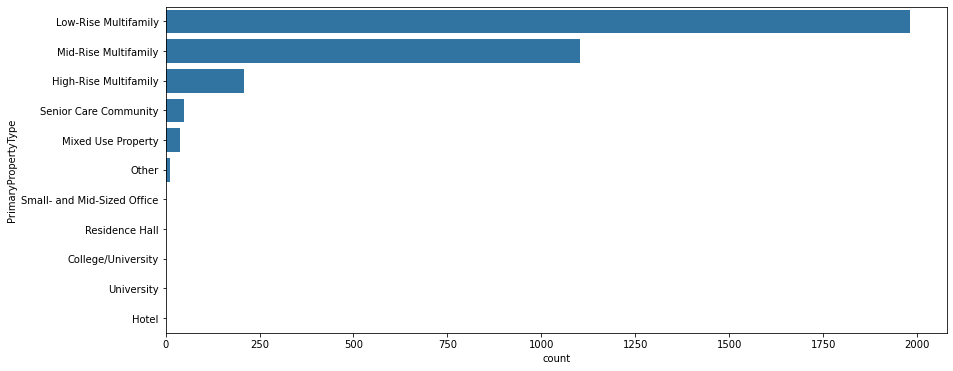

In [22]:
data_filtre = batiments_data[(batiments_data["BuildingType"] == "Multifamily LR (1-4)") |
                             (batiments_data["BuildingType"] == "Multifamily MR (5-9)") |
                             (batiments_data["BuildingType"] == "Multifamily HR (10+)")]
plt.rcParams["figure.figsize"] = (14, 6)
sns.countplot(y="PrimaryPropertyType", color='tab:blue', data=data_filtre, 
              order=data_filtre.PrimaryPropertyType.value_counts().index)

In [21]:
data_filtre["PrimaryPropertyType"].value_counts()

Low-Rise Multifamily           1980
Mid-Rise Multifamily           1103
High-Rise Multifamily           208
Senior Care Community            49
Mixed Use Property               39
Other                            12
Small- and Mid-Sized Office       2
Residence Hall                    2
College/University                1
University                        1
Hotel                             1
Name: PrimaryPropertyType, dtype: int64

Quasiment la totalité des propriétés résidentielles ont un usage principal lié à l'habitation. Ces propriétés seront supprimées.

<AxesSubplot:xlabel='count', ylabel='PrimaryPropertyType'>

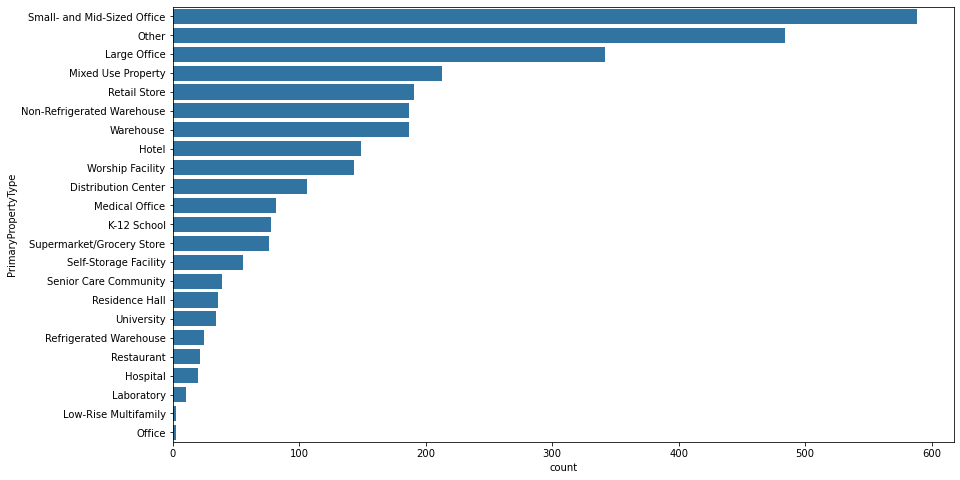

In [56]:
data_filtre = batiments_data[(batiments_data["BuildingType"] == "NonResidential") |
                             (batiments_data["BuildingType"] == "Nonresidential COS") |
                             (batiments_data["BuildingType"] == "Nonresidential WA")]
plt.rcParams["figure.figsize"] = (14, 8)
sns.countplot(y="PrimaryPropertyType", color='tab:blue', data=data_filtre, 
              order=data_filtre.PrimaryPropertyType.value_counts().index)

In [57]:
data_filtre["PrimaryPropertyType"].value_counts()

Small- and Mid-Sized Office    588
Other                          484
Large Office                   342
Mixed Use Property             213
Retail Store                   191
Non-Refrigerated Warehouse     187
Warehouse                      187
Hotel                          149
Worship Facility               143
Distribution Center            106
Medical Office                  82
K-12 School                     78
Supermarket/Grocery Store       76
Self-Storage Facility           56
Senior Care Community           39
Residence Hall                  36
University                      34
Refrigerated Warehouse          25
Restaurant                      22
Hospital                        20
Laboratory                      11
Low-Rise Multifamily             3
Office                           3
Name: PrimaryPropertyType, dtype: int64

Quasiment la totalité des propriétés non-résidentielles ont un usage principal de ce même type. Ces propriétés seront conservées.

<AxesSubplot:xlabel='count', ylabel='PrimaryPropertyType'>

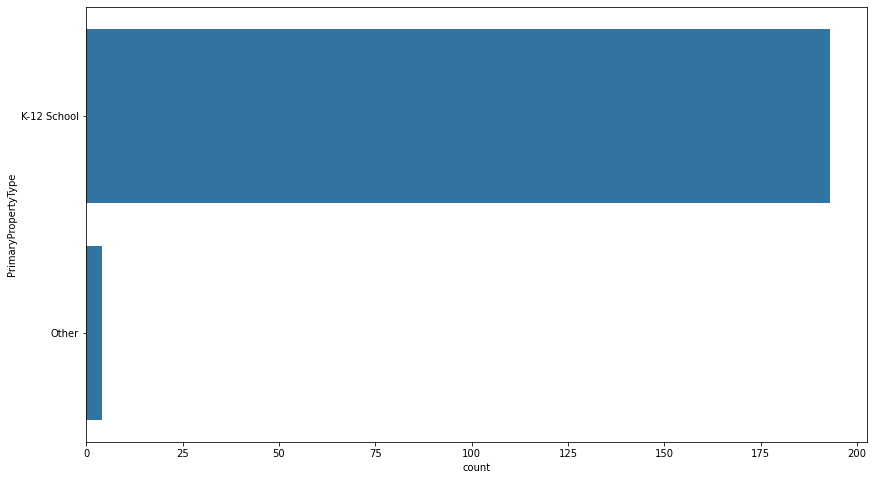

In [58]:
data_filtre = batiments_data[(batiments_data["BuildingType"] == "SPS-District K-12")]
plt.rcParams["figure.figsize"] = (14, 8)
sns.countplot(y="PrimaryPropertyType", color='tab:blue', data=data_filtre, 
              order=data_filtre.PrimaryPropertyType.value_counts().index)

Quasiment la totalité des bâtiments scolaires ont un usage principal lié à la scolarisation. Ces bâtiments seront conservés.

In [195]:
batiments_data["BuildingType"].value_counts()

NonResidential          2921
Multifamily LR (1-4)    2047
Multifamily MR (5-9)    1134
Multifamily HR (10+)     217
SPS-District K-12        197
Nonresidential COS       153
Campus                    46
Nonresidential WA          1
Name: BuildingType, dtype: int64

In [196]:
# suppression des bâtiments résidentiels
liste_types_batiments_supprimes = ["Multifamily LR (1-4)", "Multifamily MR (5-9)", "Multifamily HR (10+)"]
batiments_data = batiments_data[~batiments_data.BuildingType.isin(liste_types_batiments_supprimes)]

In [197]:
batiments_data["BuildingType"].value_counts()

NonResidential        2921
SPS-District K-12      197
Nonresidential COS     153
Campus                  46
Nonresidential WA        1
Name: BuildingType, dtype: int64

## Vérifications sur la localisation des bâtiments

In [109]:
batiments_data["City"].value_counts()

Seattle    1668
SEATTLE    1650
Name: City, dtype: int64

In [110]:
batiments_data["State"].value_counts()

WA    3318
Name: State, dtype: int64

Toutes les propriétés sont bien situées à Seattle dans l'état du Washington.

In [48]:
(min(pd.to_numeric(batiments_data["ZipCode"])), max(pd.to_numeric(batiments_data["ZipCode"])))

(98006.0, 98199.0)

L'intervalle dans lequel les codes postaux sont compris est cohérent.

## Valeurs manquantes

In [198]:
nombres_donnees_manquantes = batiments_data.isnull().sum()
nombres_donnees_totales = batiments_data.isnull().count()
pourcentages_donnees_manquantes = round(nombres_donnees_manquantes/nombres_donnees_totales*100, 1)

donnees_manquantes_df = pd.DataFrame({'nombre': nombres_donnees_manquantes, 
                                      'total': nombres_donnees_totales, 
                                      'pourcentage': pourcentages_donnees_manquantes})

donnees_manquantes_df.sort_values(by=['nombre'], ascending=False, inplace=True)

donnees_manquantes_df

,nombre,total,pourcentage
Outlier,3270,3318,98.6
SecondLargestPropertyUseType,1651,3318,49.8
ENERGYSTARScore,1107,3318,33.4
ZipCode,16,3318,0.5
GHGEmissions,9,3318,0.3
NaturalGas,9,3318,0.3
Electricity,9,3318,0.3
SteamUse,9,3318,0.3
SiteEnergyUse,9,3318,0.3
NumberofFloors,8,3318,0.2


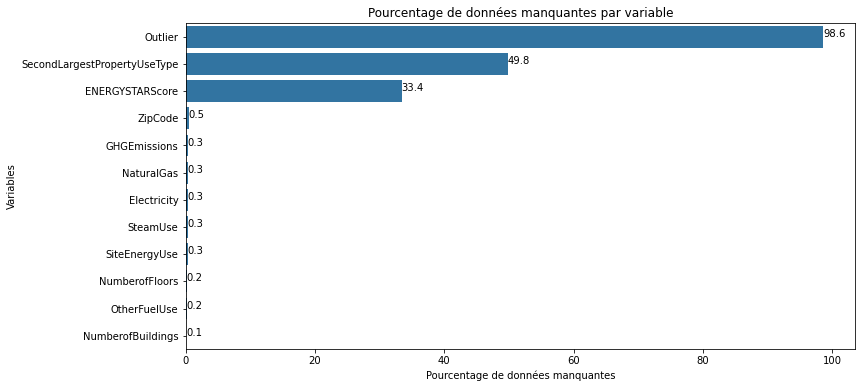

In [199]:
donnees_manquantes_df = donnees_manquantes_df[donnees_manquantes_df['nombre'] > 0]

plt.rcParams["figure.figsize"] = (12, 6)
sns.barplot(x='pourcentage', y=donnees_manquantes_df.index.values, data=donnees_manquantes_df, color='tab:blue')
plt.title('Pourcentage de données manquantes par variable')
plt.xlabel('Pourcentage de données manquantes')
plt.ylabel('Variables')

for variable, pourcentage in enumerate(donnees_manquantes_df.pourcentage):
    plt.text(pourcentage, variable, "\n" + str(pourcentage))

D'après **[la description des données](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy)**, la variable *Outlier* désigne si oui ou non la propriété est un outlier bas ou élevé. Cependant, en analysant les données, aucune indication n'est donnée pour désigner si la propriété n'est pas un outlier. On peut en déduire que les valeurs manquantes représentent les "non-outliers".

Pour l'évaluation de l'ENERGYSTAR score dans la prédiction d'émissions, une imputation sera nécessaire.

In [200]:
# Remplacement des données manquantes de Outlier par No
batiments_data.loc[batiments_data.loc[:, 'Outlier'].isna(), "Outlier"] = "No"

In [201]:
batiments_data.Outlier.value_counts()

No              3270
Low Outlier       32
High Outlier      16
Name: Outlier, dtype: int64

In [202]:
batiments_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3318 entries, 0 to 6715
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   OSEBuildingID                 3318 non-null   int64  
 1   DataYear                      3318 non-null   int64  
 2   BuildingType                  3318 non-null   object 
 3   PrimaryPropertyType           3318 non-null   object 
 4   Neighborhood                  3318 non-null   object 
 5   YearBuilt                     3318 non-null   int64  
 6   NumberofBuildings             3316 non-null   float64
 7   NumberofFloors                3310 non-null   float64
 8   PropertyGFABuilding           3318 non-null   int64  
 9   SecondLargestPropertyUseType  1667 non-null   object 
 10  ENERGYSTARScore               2211 non-null   float64
 11  SiteEnergyUse                 3309 non-null   float64
 12  SteamUse                      3309 non-null   float64
 13  Ele

## Vérifications sur la conformité des propriétés

<AxesSubplot:xlabel='count', ylabel='ComplianceStatus'>

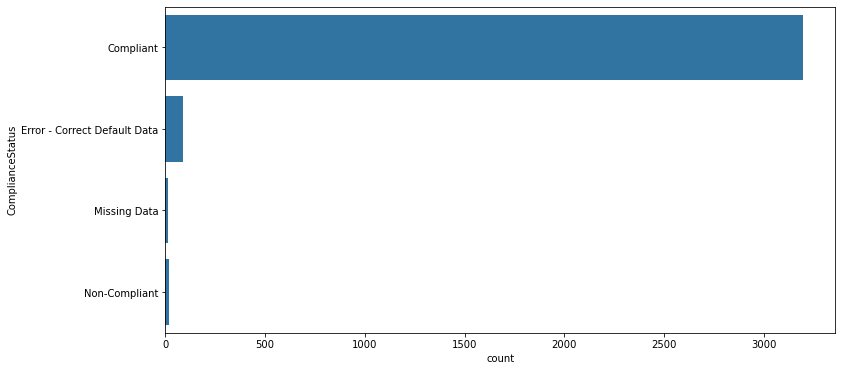

In [100]:
plt.rcParams["figure.figsize"] = (12, 6)
sns.countplot(y="ComplianceStatus", data=batiments_data, color='tab:blue')

Je supprime les propriétés avec des données manquantes et non conforme.

In [203]:
len(batiments_data)

3318

In [204]:
index_proprietes_data_manquantes_non_conforme = batiments_data[(batiments_data.ComplianceStatus == "Non-Compliant") | 
                                                               (batiments_data.ComplianceStatus == "Missing Data")].index
batiments_data.drop(index=index_proprietes_data_manquantes_non_conforme, inplace=True)
batiments_data.reset_index(drop=True, inplace=True)

In [205]:
len(batiments_data)

3286

## Vérifications de doublons parmi les propriétés

In [206]:
occurences_ID_proprietes = pd.DataFrame(batiments_data.OSEBuildingID.value_counts())
liste_ID_proprietes_doublons = occurences_ID_proprietes[occurences_ID_proprietes.OSEBuildingID > 1].index.values

In [207]:
len(liste_ID_proprietes_doublons)

1588

Il y a 1588 propriétés non-résidentielles en doublons. Regardons le nombre de propriétés ayant au moins une caractéristique différente.

In [208]:
batiments_doublons_data = batiments_data[batiments_data.OSEBuildingID.isin(liste_ID_proprietes_doublons)]
batiments_doublons_data = batiments_doublons_data.sort_values(by=['OSEBuildingID', 'DataYear'])

# l'ID fait partie des caractéristiques sinon les comparaisons seront sur tous les bâtiments et non les doublons entre eux
caracteristiques = ["OSEBuildingID", "BuildingType", "PrimaryPropertyType", "Neighborhood",  
                    "YearBuilt", "NumberofBuildings", "NumberofFloors", "PropertyGFABuilding"]

In [209]:
analyse_doublons = batiments_doublons_data.drop_duplicates(subset=caracteristiques, keep="last")
analyse_doublons = analyse_doublons.sort_values(by=['OSEBuildingID', 'DataYear'])

# comptage des occurrences des bâtiments => 1 = mêmes caractéristiques et 2 = caractéristiques différentes
groupby_batiment = analyse_doublons.groupby(["OSEBuildingID"])
nb_occurences = pd.DataFrame(groupby_batiment["DataYear"].count())
id_batiments_meme_caracteristiques = nb_occurences[nb_occurences.DataYear == 1].index
id_batiments_differentes_caracteristiques = nb_occurences[nb_occurences.DataYear == 2].index

In [210]:
len(id_batiments_meme_caracteristiques)

1196

In [211]:
len(id_batiments_differentes_caracteristiques)

392

In [212]:
len(id_batiments_differentes_caracteristiques)/len(liste_ID_proprietes_doublons)*100

24.68513853904282

J'obtiens 392 propriétés ayant au moins une caractéristique différente de son doublon soit 24,7% d'entre elles. Etudions les bâtiments doublons avec les mêmes caractéristiques pour voir si leurs consommations d'énergie et leurs émissions de GES sont si différentes entre elles.

In [213]:
# calculs des différences et des moyennes des valeurs de chaque pair de doublons
batiments_doublons_meme_caracteristiques = batiments_doublons_data[batiments_data.OSEBuildingID.isin(id_batiments_meme_caracteristiques)]
variables_etudiees = ["OSEBuildingID", "SiteEnergyUse", "GHGEmissions"]
batiments_doublons_meme_caracteristiques = batiments_doublons_meme_caracteristiques[variables_etudiees]
groupby_batiment = batiments_doublons_meme_caracteristiques.groupby(["OSEBuildingID"])
batiments_doublons_meme_caracteristiques["diff_SiteEnergyUse"] = groupby_batiment["SiteEnergyUse"].diff().abs()
batiments_doublons_meme_caracteristiques["diff_GHGEmissions"] = groupby_batiment["GHGEmissions"].diff().abs()
moyennes_batiments = groupby_batiment[["SiteEnergyUse", "GHGEmissions"]].mean()

# on joint les infos de la moyenne et de la différence
batiments_doublons_meme_caracteristiques = batiments_doublons_meme_caracteristiques.merge(moyennes_batiments, 
                                                                                          how="left", 
                                                                                          on="OSEBuildingID",
                                                                                          suffixes=("", "_moy"))

# calculs des rapports différences/moyennes pour évaluer l'ordre de grandeur de la différence
variables_analyse_diff = ["OSEBuildingID", "diff_SiteEnergyUse", "diff_GHGEmissions", "SiteEnergyUse_moy", "GHGEmissions_moy"]
analyse_differences = batiments_doublons_meme_caracteristiques[variables_analyse_diff].dropna()
analyse_differences["rapport_diff_moy_SiteEnergyUse"] = analyse_differences.diff_SiteEnergyUse / analyse_differences.SiteEnergyUse_moy
analyse_differences["rapport_diff_moy_GHGEmissions"] = analyse_differences.diff_GHGEmissions / analyse_differences.GHGEmissions_moy
analyse_differences[["rapport_diff_moy_SiteEnergyUse", "rapport_diff_moy_GHGEmissions"]].describe()

<ipython-input-213-19ead9b06b5e>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  batiments_doublons_meme_caracteristiques = batiments_doublons_data[batiments_data.OSEBuildingID.isin(id_batiments_meme_caracteristiques)]


,rapport_diff_moy_SiteEnergyUse,rapport_diff_moy_GHGEmissions
count,1191.000000,1191.000000
mean,0.104939,0.139740
std,0.179979,0.211631
min,0.000046,0.000000
25%,0.023005,0.031024
50%,0.054821,0.078975
75%,0.112547,0.158423
max,2.000000,2.000000


<AxesSubplot:xlabel='rapport_diff_moy_SiteEnergyUse'>

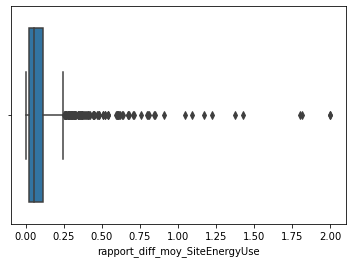

In [165]:
sns.boxplot(x="rapport_diff_moy_SiteEnergyUse", data=analyse_differences)

<AxesSubplot:xlabel='rapport_diff_moy_GHGEmissions'>

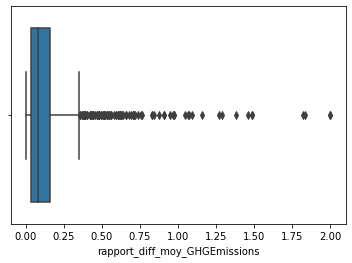

In [166]:
sns.boxplot(x="rapport_diff_moy_GHGEmissions", data=analyse_differences)

Pour 75% des propriétés, la différence entre doublons sur la consommation d'énergie et les émissions de GES représente jusqu'à 15% des moyennes respectives. *Attention à bien avoir en tête que la différence et la moyenne se calculent sur une paire de doublons.*

Autrement dit, pour la majeure partie des propriétés il y a peu de différences entre leurs doublons sur les valeurs de consommation d'énergie et d'émissions de GES.

Regardons de plus près les propriétés avec des ratios supérieurs ou égal à 20%. Au delà de ce seuil, les valeurs commencent vraiment à s'éloigner l'une de l'autre. Il serait alors intéressant de conserver ces données.

In [214]:
hauts_ratios = analyse_differences[(analyse_differences.rapport_diff_moy_GHGEmissions >= 0.2) |
                                   (analyse_differences.rapport_diff_moy_SiteEnergyUse >= 0.2)]
id_batiments_hauts_ratios = hauts_ratios.OSEBuildingID

In [215]:
len(id_batiments_hauts_ratios)

237

In [216]:
len(id_batiments_hauts_ratios)/len(analyse_differences)*100

19.899244332493705

237 des propriétés ayant les mêmes caractéristiques entre doublons (soit 20% des concernées) ont des valeurs différentes et éloignées l'une de l'autre.

In [217]:
proprietes_valeurs_differentes = batiments_doublons_data[batiments_doublons_data.OSEBuildingID.isin(id_batiments_hauts_ratios)]
colonnes_conservees = ["OSEBuildingID", "SiteEnergyUse", "SteamUse", "Electricity", "NaturalGas", 
                       "OtherFuelUse", "GHGEmissions", "ComplianceStatus", "Outlier"]
proprietes_valeurs_differentes = proprietes_valeurs_differentes[colonnes_conservees]
proprietes_valeurs_differentes.head(30)

,OSEBuildingID,SiteEnergyUse,SteamUse,Electricity,NaturalGas,OtherFuelUse,GHGEmissions,ComplianceStatus,Outlier
3,5,2.822932e+07,23458518.00,2769023.0,2001894.0,0.0,1936.34,Compliant,High Outlier
1653,5,6.794584e+06,2214446.25,2768924.0,1811213.0,0.0,286.43,Compliant,No
18,25,7.845112e+06,3205497.00,1790665.0,2849024.0,0.0,411.22,Compliant,No
1668,25,1.015461e+07,3430862.00,5908370.0,815376.0,0.0,349.32,Compliant,No
19,26,5.333265e+07,0.00,26798906.0,26534856.0,0.0,1596.08,Compliant,No
1669,26,4.498447e+07,0.00,24357833.0,20626631.0,0.0,1265.29,Compliant,No
23,30,9.791557e+06,0.00,4582663.0,5209084.0,0.0,308.60,Compliant,No
1673,30,1.134369e+07,0.00,4647474.0,6696211.0,0.0,388.04,Compliant,No
38,53,2.137686e+06,0.00,1226016.0,911721.0,0.0,56.97,Compliant,No
1687,53,2.951331e+06,0.00,1579749.0,1371582.0,0.0,83.86,Compliant,No


Les différences sont suffisamment importantes au seuil de 20%, par conséquent, je garderai toutes les propriétés (et leurs doublons) ayant atteint ce seuil dans l'analyse et la construction des modèles.

J'ai besoin de supprimer un des deux doublons (celui de 2015) qui ont les mêmes caractéristiques et des valeurs de consommations d'énergie et d'émissions de GES relativement semblables entre elles. Pour ce faire, j'ai besoin d'identifier l'index de ces 959 propriétés et non pas leur ID.

NB : 1588 propriétés en doublons - les 392 propriétés avec des caractéristiques différentes - les 237 propriétés avec des valeurs différentes = 959 propriétés avec des caractéristiques et valeurs semblables.

In [218]:
id_batiments_doublons_gardes = id_batiments_differentes_caracteristiques.values.tolist()
id_batiments_doublons_gardes += id_batiments_hauts_ratios.values.tolist()

In [219]:
len(id_batiments_doublons_gardes)

629

In [220]:
# on récupère les index des doublons à supprimer du dataset
batiments_doublons_ecartes = batiments_doublons_data[~batiments_doublons_data.OSEBuildingID.isin(id_batiments_doublons_gardes)]
batiments_doublons_ecartes = batiments_doublons_ecartes.drop_duplicates(subset=caracteristiques, keep="first")
index_batiments_doublons_ecartes = batiments_doublons_ecartes.index

In [221]:
batiments_data.drop(index=index_batiments_doublons_ecartes, inplace=True)
batiments_data.reset_index(drop=True, inplace=True)

In [222]:
batiments_data[batiments_data.OSEBuildingID.isin(batiments_doublons_ecartes.OSEBuildingID)].DataYear.describe()

count     959.0
mean     2016.0
std         0.0
min      2016.0
25%      2016.0
50%      2016.0
75%      2016.0
max      2016.0
Name: DataYear, dtype: float64

In [223]:
len(batiments_data)

2327

# Analyses exploratoires

In [55]:
batiments_data.describe()

,OSEBuildingID,DataYear,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding,ENERGYSTARScore,SiteEnergyUse,SteamUse,Electricity,NaturalGas,OtherFuelUse,GHGEmissions
count,2327.000000,2327.000000,2327.000000,2327.000000,2319.000000,2.327000e+03,1535.000000,2.325000e+03,2.325000e+03,2.325000e+03,2.325000e+03,2.325000e+03,2325.000000
mean,16546.433606,2015.703051,1961.885260,1.156854,3.908150,1.040955e+05,64.629967,8.435271e+06,5.867864e+05,5.700751e+06,2.053423e+06,8.986192e+03,194.091884
std,13839.218688,0.457012,32.436765,2.636615,6.203392,2.585860e+05,29.156233,2.861893e+07,6.124540e+06,1.900045e+07,9.153794e+06,2.311658e+05,774.563340
min,1.000000,2015.000000,1900.000000,0.000000,0.000000,-5.055000e+04,1.000000,0.000000e+00,0.000000e+00,-1.154170e+05,0.000000e+00,0.000000e+00,-0.800000
25%,603.500000,2015.000000,1930.000000,1.000000,1.000000,2.851550e+04,46.000000,1.191803e+06,0.000000e+00,6.886420e+05,0.000000e+00,0.000000e+00,19.250000
50%,21208.000000,2016.000000,1966.000000,1.000000,2.000000,4.800100e+04,73.000000,2.409429e+06,0.000000e+00,1.541206e+06,4.949600e+05,0.000000e+00,48.650000
75%,24603.500000,2016.000000,1988.000000,1.000000,4.000000,9.480650e+04,89.000000,6.689184e+06,0.000000e+00,4.663661e+06,1.464372e+06,0.000000e+00,134.690000
max,50226.000000,2016.000000,2015.000000,111.000000,99.000000,9.320156e+06,100.000000,8.739237e+08,1.349435e+08,6.570744e+08,2.979090e+08,8.269669e+06,16870.980000


Voici les valeurs extrêmes relevées dans le dataset :
- surface totale de la propriété négative
- consommation d'électricité négative
- émissions de GES négatives
- nombre de bâtiments allant de 0 à 111
- nombre d'étages variant de 0 à 99, ce qui est plausible pour une tour (très haute)

Les propriétés concernées par ces valeurs feront l'objet d'une étude plus approfondie.

## Gestion des valeurs aberrantes

### Surface totale négative de la propriété

In [224]:
batiments_data[batiments_data.PropertyGFABuilding < 0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding,SecondLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse,SteamUse,Electricity,NaturalGas,ComplianceStatus,Outlier,OtherFuelUse,GHGEmissions,Address,City,State,ZipCode
638,29788,2015,NonResidential,Small- and Mid-Sized Office,MAGNOLIA / QUEEN ANNE,1982,1.0,5.0,-43310,NaN,65.0,3455247.0,0.0,3455391.0,0.0,Compliant,No,0.0,24.09,220 W MERCER ST,SEATTLE,WA,98119
690,50002,2015,NonResidential,Other,NORTHEAST,2014,1.0,3.0,-50550,Automobile Dealership,NaN,1389553.0,0.0,1389610.0,0.0,Compliant,No,0.0,9.69,4741 11TH AVE NE,SEATTLE,WA,98105


Je vais supprimer ces valeurs aberrantes.

In [225]:
batiments_data.loc[batiments_data.PropertyGFABuilding < 0, ["PropertyGFABuilding"]] = np.nan

In [226]:
batiments_data[batiments_data.PropertyGFABuilding < 0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding,SecondLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse,SteamUse,Electricity,NaturalGas,ComplianceStatus,Outlier,OtherFuelUse,GHGEmissions,Address,City,State,ZipCode


In [227]:
batiments_data.describe()

,OSEBuildingID,DataYear,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding,ENERGYSTARScore,SiteEnergyUse,SteamUse,Electricity,NaturalGas,OtherFuelUse,GHGEmissions
count,2327.000000,2327.000000,2327.000000,2327.000000,2319.000000,2.325000e+03,1535.000000,2.325000e+03,2.325000e+03,2.325000e+03,2.325000e+03,2.325000e+03,2325.000000
mean,16546.433606,2015.703051,1961.885260,1.156854,3.908150,1.042254e+05,64.629967,8.435271e+06,5.867864e+05,5.700751e+06,2.053423e+06,8.986192e+03,194.091884
std,13839.218688,0.457012,32.436765,2.636615,6.203392,2.586593e+05,29.156233,2.861893e+07,6.124540e+06,1.900045e+07,9.153794e+06,2.311658e+05,774.563340
min,1.000000,2015.000000,1900.000000,0.000000,0.000000,3.636000e+03,1.000000,0.000000e+00,0.000000e+00,-1.154170e+05,0.000000e+00,0.000000e+00,-0.800000
25%,603.500000,2015.000000,1930.000000,1.000000,1.000000,2.856800e+04,46.000000,1.191803e+06,0.000000e+00,6.886420e+05,0.000000e+00,0.000000e+00,19.250000
50%,21208.000000,2016.000000,1966.000000,1.000000,2.000000,4.800600e+04,73.000000,2.409429e+06,0.000000e+00,1.541206e+06,4.949600e+05,0.000000e+00,48.650000
75%,24603.500000,2016.000000,1988.000000,1.000000,4.000000,9.490000e+04,89.000000,6.689184e+06,0.000000e+00,4.663661e+06,1.464372e+06,0.000000e+00,134.690000
max,50226.000000,2016.000000,2015.000000,111.000000,99.000000,9.320156e+06,100.000000,8.739237e+08,1.349435e+08,6.570744e+08,2.979090e+08,8.269669e+06,16870.980000


### Consommation d'électricité et émissions de GES négatives

In [228]:
batiments_data[batiments_data.Electricity < 0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding,SecondLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse,SteamUse,Electricity,NaturalGas,ComplianceStatus,Outlier,OtherFuelUse,GHGEmissions,Address,City,State,ZipCode
2264,49784,2016,NonResidential,Small- and Mid-Sized Office,CENTRAL,2013,1.0,6.0,52000.0,NaN,100.0,342726.0938,0.0,-115417.0,0.0,Compliant,No,0.0,-0.8,1501 E. Madison St.,Seattle,WA,98122


Les données de cette propriété ne sont pas cohérentes. En effet, la consommation d'électricité est négative, de même que les émissions de GES. De plus, sa consommation d'énergie est bien positive et dans le même temps les consommations des autres énergies que l'électricité sont nulles.

Je supprime donc cette propriété.

In [229]:
index_proprietes_elec_neg = batiments_data[batiments_data.Electricity < 0].index
batiments_data.drop(index=index_proprietes_elec_neg, inplace=True)

In [230]:
batiments_data[batiments_data.Electricity < 0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding,SecondLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse,SteamUse,Electricity,NaturalGas,ComplianceStatus,Outlier,OtherFuelUse,GHGEmissions,Address,City,State,ZipCode


In [231]:
batiments_data.describe()

,OSEBuildingID,DataYear,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding,ENERGYSTARScore,SiteEnergyUse,SteamUse,Electricity,NaturalGas,OtherFuelUse,GHGEmissions
count,2326.000000,2326.000000,2326.000000,2326.000000,2318.000000,2.324000e+03,1534.000000,2.324000e+03,2.324000e+03,2.324000e+03,2.324000e+03,2.324000e+03,2324.000000
mean,16532.144024,2015.702923,1961.863285,1.156922,3.907248,1.042479e+05,64.606910,8.438753e+06,5.870389e+05,5.703254e+06,2.054306e+06,8.990059e+03,194.175744
std,13825.013212,0.457069,32.426410,2.637180,6.204578,2.587126e+05,29.151738,2.862460e+07,6.125846e+06,1.900416e+07,9.155664e+06,2.312155e+05,774.719481
min,1.000000,2015.000000,1900.000000,0.000000,0.000000,3.636000e+03,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,603.250000,2015.000000,1930.000000,1.000000,1.000000,2.855875e+04,46.000000,1.194325e+06,0.000000e+00,6.923545e+05,0.000000e+00,0.000000e+00,19.272500
50%,21208.000000,2016.000000,1965.500000,1.000000,2.000000,4.800350e+04,73.000000,2.410416e+06,0.000000e+00,1.543774e+06,4.955280e+05,0.000000e+00,48.695000
75%,24603.000000,2016.000000,1988.000000,1.000000,4.000000,9.491200e+04,89.000000,6.695685e+06,0.000000e+00,4.665362e+06,1.464761e+06,0.000000e+00,134.717500
max,50226.000000,2016.000000,2015.000000,111.000000,99.000000,9.320156e+06,100.000000,8.739237e+08,1.349435e+08,6.570744e+08,2.979090e+08,8.269669e+06,16870.980000


J'observe maintenant qu'il existe des propriétés sans aucune consommation d'énergie ni d'émissions de GES. Or, à ce jour, il me paraît aberrant qu'un bâtiment urbain ne consomme pas d'énergie, de facto n'émette pas de GES. Je vais donc étudier ces propriétés.

### Consommation d'énergie et émissions de GES nulles

In [232]:
batiments_data[(batiments_data.SiteEnergyUse == 0)]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding,SecondLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse,SteamUse,Electricity,NaturalGas,ComplianceStatus,Outlier,OtherFuelUse,GHGEmissions,Address,City,State,ZipCode
12,58,2015,NonResidential,Retail Store,DOWNTOWN,1920,1.0,2.0,57428.0,Non-Refrigerated Warehouse,NaN,0.0,0.0,0.0,0.0,Compliant,No,0.0,0.0,1525 4TH AVE,SEATTLE,WA,98101
215,765,2015,NonResidential,Large Office,DOWNTOWN,1929,1.0,27.0,203251.0,Parking,NaN,0.0,0.0,0.0,0.0,Compliant,No,0.0,0.0,1218 3RD AVE,SEATTLE,WA,98101
1613,21616,2016,SPS-District K-12,K-12 School,NORTH,1954,1.0,1.0,42292.0,NaN,100.0,0.0,0.0,0.0,0.0,Error - Correct Default Data,No,0.0,0.0,13018 20th Ave. N.E.,Seattle,WA,98125


Ces propriétés seront toutes supprimées.

In [233]:
index_batiments_sans_conso_energie = batiments_data[(batiments_data.SiteEnergyUse == 0)].index

In [234]:
batiments_data.drop(index=index_batiments_sans_conso_energie, inplace=True)

In [235]:
batiments_data[(batiments_data.SiteEnergyUse == 0)]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding,SecondLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse,SteamUse,Electricity,NaturalGas,ComplianceStatus,Outlier,OtherFuelUse,GHGEmissions,Address,City,State,ZipCode


In [236]:
len(batiments_data)

2323

In [237]:
batiments_data[(batiments_data.GHGEmissions == 0)]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding,SecondLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse,SteamUse,Electricity,NaturalGas,ComplianceStatus,Outlier,OtherFuelUse,GHGEmissions,Address,City,State,ZipCode
1181,700,2016,NonResidential,Supermarket/Grocery Store,MAGNOLIA / QUEEN ANNE,2008,1.0,1.0,57176.0,Retail Store,31.0,12525174.0,0.0,0.0,0.0,Compliant,No,0.0,0.0,2001 15th Avenue West,Seattle,WA,98119


Ici encore, il est aberrant que cette propriété ait une consommation totale d'énergie positive sans aucune consommation dans les différents types d'énergie ni d'émissions de GES. Elle sera supprimée également.

In [238]:
index_batiments_conso_energie_incoherente = batiments_data[(batiments_data.GHGEmissions == 0)].index
batiments_data.drop(index=index_batiments_conso_energie_incoherente, inplace=True)

In [239]:
batiments_data[(batiments_data.GHGEmissions == 0)]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding,SecondLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse,SteamUse,Electricity,NaturalGas,ComplianceStatus,Outlier,OtherFuelUse,GHGEmissions,Address,City,State,ZipCode


In [240]:
batiments_data.describe()

,OSEBuildingID,DataYear,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding,ENERGYSTARScore,SiteEnergyUse,SteamUse,Electricity,NaturalGas,OtherFuelUse,GHGEmissions
count,2322.000000,2322.000000,2322.000000,2322.000000,2314.000000,2.320000e+03,1532.000000,2.320000e+03,2.320000e+03,2.320000e+03,2.320000e+03,2.320000e+03,2320.000000
mean,16550.658053,2015.703273,1961.878984,1.157192,3.900605,1.042724e+05,64.605744,8.447904e+06,5.880510e+05,5.713087e+06,2.057848e+06,9.005559e+03,194.510530
std,13824.502502,0.456914,32.420977,2.639444,6.190629,2.589206e+05,29.144092,2.864754e+07,6.131078e+06,1.901907e+07,9.163159e+06,2.314145e+05,775.345332
min,1.000000,2015.000000,1900.000000,0.000000,0.000000,3.636000e+03,1.000000,1.144100e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.080000
25%,603.250000,2015.000000,1930.250000,1.000000,1.000000,2.852325e+04,46.000000,1.200180e+06,0.000000e+00,6.972848e+05,0.000000e+00,0.000000e+00,19.390000
50%,21210.000000,2016.000000,1966.000000,1.000000,2.000000,4.799650e+04,73.000000,2.414402e+06,0.000000e+00,1.550824e+06,4.964455e+05,0.000000e+00,48.855000
75%,24603.750000,2016.000000,1988.000000,1.000000,4.000000,9.491200e+04,89.000000,6.695685e+06,0.000000e+00,4.671698e+06,1.467290e+06,0.000000e+00,134.805000
max,50226.000000,2016.000000,2015.000000,111.000000,99.000000,9.320156e+06,100.000000,8.739237e+08,1.349435e+08,6.570744e+08,2.979090e+08,8.269669e+06,16870.980000


### Nombre de bâtiments

<AxesSubplot:xlabel='NumberofBuildings'>

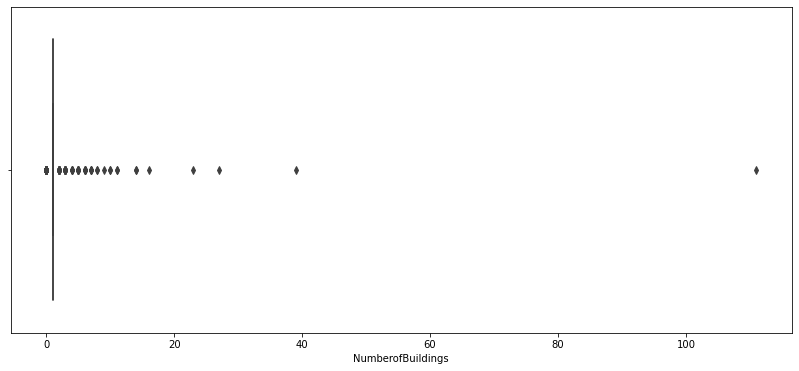

In [255]:
plt.figure(figsize=(14, 6))
sns.boxplot(x="NumberofBuildings", data=batiments_data, color='tab:blue')

Les propriétés n'ayant pas de bâtiment ou en ayant 2 ou plus sont des outliers. Cependant, je vais regarder plus en détails les propriétés sans bâtiment et ceux en ayant au moins 6.

#### Propriétés sans bâtiment

In [241]:
batiments_data[batiments_data.NumberofBuildings == 0].describe()

,OSEBuildingID,DataYear,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding,ENERGYSTARScore,SiteEnergyUse,SteamUse,Electricity,NaturalGas,OtherFuelUse,GHGEmissions
count,52.000000,52.0,52.000000,52.0,52.000000,5.200000e+01,24.000000,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01,52.0,52.000000
mean,17239.615385,2016.0,1961.346154,0.0,3.826923,1.091758e+05,56.875000,9.237048e+06,3.060435e+05,6.216962e+06,2.723593e+06,0.0,211.614038
std,15040.091242,0.0,33.627652,0.0,4.470913,2.013682e+05,28.312407,1.449101e+07,2.160978e+06,1.101858e+07,4.682776e+06,0.0,344.959934
min,89.000000,2016.0,1900.000000,0.0,0.000000,2.041100e+04,6.000000,2.877635e+05,0.000000e+00,2.877630e+05,0.000000e+00,0.0,2.010000
25%,592.500000,2016.0,1929.000000,0.0,2.000000,2.919350e+04,34.750000,2.097714e+06,0.000000e+00,1.106552e+06,6.744775e+04,0.0,30.592500
50%,21258.000000,2016.0,1968.000000,0.0,3.000000,5.556100e+04,58.000000,3.950807e+06,0.000000e+00,2.569620e+06,1.004594e+06,0.0,69.735000
75%,25858.750000,2016.0,1987.750000,0.0,4.000000,9.934750e+04,79.000000,7.468450e+06,0.000000e+00,5.194010e+06,2.486347e+06,0.0,174.812500
max,49924.000000,2016.0,2013.000000,0.0,24.000000,1.380959e+06,100.000000,7.413058e+07,1.558601e+07,6.776055e+07,2.241366e+07,0.0,1468.500000


In [242]:
batiments_data[(batiments_data.NumberofBuildings == 0) & (batiments_data.NumberofFloors == 0)]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding,SecondLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse,SteamUse,Electricity,NaturalGas,ComplianceStatus,Outlier,OtherFuelUse,GHGEmissions,Address,City,State,ZipCode
1159,657,2016,NonResidential,Mixed Use Property,DOWNTOWN,2006,0.0,0.0,516407.0,Multifamily Housing,31.0,39403320.0,0.0,29432803.0,9970512.0,Compliant,No,0.0,734.72,2200 Westlake Ave.,Seattle,WA,98121


Les 52 propriétés sans bâtiment ont une surface totale, une consommation totale d'énergie et des émissions de GES de renseignés. Et 51 d'entre elles ont un nombre d'étages de renseigné. Cela doit être des erreurs de saisie.

À noter que toutes ces propriétés sont concernées par les relevés de 2016. Regardons si elles ont fait l'objet d'un relevé en 2015, je pourrais peut-être récupérer cette information dans ces données.

In [243]:
liste_proprietes_sans_batiment = batiments_data[batiments_data.NumberofBuildings == 0]["OSEBuildingID"]

In [244]:
donnees_2015_proprietes_sans_batiment = batiments_data[(batiments_data.OSEBuildingID.isin(liste_proprietes_sans_batiment)) &
                                                       (batiments_data.DataYear == 2015)]
len(donnees_2015_proprietes_sans_batiment)

52

In [245]:
donnees_2015_proprietes_sans_batiment.NumberofBuildings.describe()

count    52.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: NumberofBuildings, dtype: float64

Toutes les propriétés sans bâtiment sur 2016 ont des données de 2015. Et surtout, elles ont toutes un seul bâtiment de renseigné. Cette valeur sera donc reportée sur 2016.

In [246]:
batiments_data.loc[batiments_data.NumberofBuildings == 0, ["NumberofBuildings"]] = 1

In [247]:
batiments_data[batiments_data.NumberofBuildings == 0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding,SecondLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse,SteamUse,Electricity,NaturalGas,ComplianceStatus,Outlier,OtherFuelUse,GHGEmissions,Address,City,State,ZipCode


#### Propriétés avec un nombre élevé de bâtiments

In [248]:
batiments_data[batiments_data.NumberofBuildings >= 6].sort_values(by=['NumberofBuildings'], ascending=False)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding,SecondLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse,SteamUse,Electricity,NaturalGas,ComplianceStatus,Outlier,OtherFuelUse,GHGEmissions,Address,City,State,ZipCode
2286,49967,2016,Campus,University,NORTHEAST,1900,111.0,0.0,9320156.0,NaN,NaN,8.739237e+08,84985240.0,657074389.0,0.0,Compliant,No,0.0,11140.56,NE 45th St & Brooklyn Ave,Seattle,WA,98105
389,22062,2015,Campus,University,EAST,1939,39.0,2.0,2200000.0,Parking,NaN,1.150801e+08,0.0,62416157.0,52666569.0,Compliant,No,0.0,3232.23,901 12TH AVE,SEATTLE,WA,98122
789,172,2016,Campus,University,DELRIDGE,1970,27.0,2.0,441071.0,NaN,NaN,3.830174e+07,0.0,25314575.0,12987166.0,Compliant,No,0.0,866.23,6000 16th Ave SW,Seattle,WA,98106
1769,23622,2016,Campus,Other,MAGNOLIA / QUEEN ANNE,1955,23.0,1.0,260241.0,NaN,NaN,3.401298e+07,0.0,26894616.0,7118362.0,Compliant,No,0.0,565.55,1900 West Nickerson Street,Seattle,WA,98119
54,261,2015,Campus,Large Office,GREATER DUWAMISH,1980,16.0,2.0,302494.0,Laboratory,NaN,5.227379e+07,0.0,44866796.0,7408855.0,Compliant,No,0.0,706.26,1420 S TRENTON ST,SEATTLE,WA,98108
1984,25251,2016,Campus,University,MAGNOLIA / QUEEN ANNE,1945,14.0,2.0,537000.0,NaN,NaN,9.060964e+07,0.0,22619097.0,67990538.0,Compliant,No,0.0,3768.66,3307 3rd Ave. W,Seattle,WA,98119
843,261,2016,Campus,Large Office,GREATER DUWAMISH,1980,14.0,2.0,302494.0,Laboratory,NaN,5.346668e+07,0.0,45321378.0,8145300.0,Compliant,No,0.0,748.55,1420 S Trenton,Seattle,WA,98108
812,211,2016,Campus,University,NORTHWEST,1970,11.0,2.0,582447.0,NaN,NaN,3.589148e+07,0.0,33450832.0,2440648.0,Compliant,No,0.0,362.82,9600 COLLEGE WAY N,Seattle,WA,98103
466,24086,2015,Campus,Other,GREATER DUWAMISH,1991,10.0,NaN,180796.0,Parking,NaN,2.993920e+07,0.0,16720050.0,13219839.0,Compliant,No,0.0,818.66,1333 AIRPORT WAY S,SEATTLE,WA,98134
1830,24086,2016,Campus,Other,GREATER DUWAMISH,1991,10.0,0.0,230971.0,Parking,NaN,2.102229e+07,0.0,15419770.0,5602515.0,Compliant,No,0.0,405.05,1333 AIRPORT WAY S,Seattle,WA,98134


Les valeurs semblent cohérentes par rapport à l'utilisation faite de la propriété, elles seront conservées et considérées comme des valeurs atypiques.

In [249]:
batiments_data.describe()

,OSEBuildingID,DataYear,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding,ENERGYSTARScore,SiteEnergyUse,SteamUse,Electricity,NaturalGas,OtherFuelUse,GHGEmissions
count,2322.000000,2322.000000,2322.000000,2322.000000,2314.000000,2.320000e+03,1532.000000,2.320000e+03,2.320000e+03,2.320000e+03,2.320000e+03,2.320000e+03,2320.000000
mean,16550.658053,2015.703273,1961.878984,1.179587,3.900605,1.042724e+05,64.605744,8.447904e+06,5.880510e+05,5.713087e+06,2.057848e+06,9.005559e+03,194.510530
std,13824.502502,0.456914,32.420977,2.633764,6.190629,2.589206e+05,29.144092,2.864754e+07,6.131078e+06,1.901907e+07,9.163159e+06,2.314145e+05,775.345332
min,1.000000,2015.000000,1900.000000,1.000000,0.000000,3.636000e+03,1.000000,1.144100e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.080000
25%,603.250000,2015.000000,1930.250000,1.000000,1.000000,2.852325e+04,46.000000,1.200180e+06,0.000000e+00,6.972848e+05,0.000000e+00,0.000000e+00,19.390000
50%,21210.000000,2016.000000,1966.000000,1.000000,2.000000,4.799650e+04,73.000000,2.414402e+06,0.000000e+00,1.550824e+06,4.964455e+05,0.000000e+00,48.855000
75%,24603.750000,2016.000000,1988.000000,1.000000,4.000000,9.491200e+04,89.000000,6.695685e+06,0.000000e+00,4.671698e+06,1.467290e+06,0.000000e+00,134.805000
max,50226.000000,2016.000000,2015.000000,111.000000,99.000000,9.320156e+06,100.000000,8.739237e+08,1.349435e+08,6.570744e+08,2.979090e+08,8.269669e+06,16870.980000


### Nombre d'étages

<AxesSubplot:xlabel='NumberofFloors'>

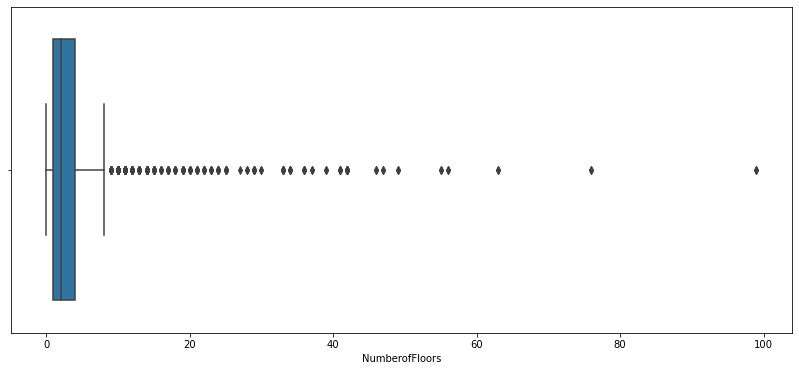

In [264]:
plt.figure(figsize=(14, 6))
sns.boxplot(x="NumberofFloors", data=batiments_data, color='tab:blue')

Les outliers concernent les propriétés avec au moins 10 étages. Regardons plus en détails les propriétés avec au moins 30 étages.

In [250]:
batiments_data[batiments_data.NumberofFloors >= 30].sort_values(by=['NumberofFloors'], ascending=False)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding,SecondLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse,SteamUse,Electricity,NaturalGas,ComplianceStatus,Outlier,OtherFuelUse,GHGEmissions,Address,City,State,ZipCode
1611,21611,2016,NonResidential,Worship Facility,GREATER DUWAMISH,1977,1.0,99.0,21948.0,NaN,80.0,3.260012e+05,0.000000e+00,326001.0,0.0,Compliant,No,0.0,2.27,5801 Beacon Avenue South,Seattle,WA,98108
1226,775,2016,NonResidential,Large Office,DOWNTOWN,1985,1.0,76.0,1632820.0,Parking,86.0,9.293764e+07,0.000000e+00,87851862.0,5085763.0,Compliant,No,0.0,882.56,701 5th Avenue,Seattle,WA,98104
71,357,2015,Nonresidential COS,Large Office,DOWNTOWN,1990,1.0,63.0,1035787.0,Parking,82.0,6.471565e+07,0.000000e+00,64696526.0,21804.0,Compliant,No,0.0,452.16,700 5TH AVE,SEATTLE,WA,98104
908,357,2016,Nonresidential COS,Large Office,DOWNTOWN,1990,1.0,63.0,1195387.0,Parking,89.0,6.157618e+07,0.000000e+00,61576180.0,0.0,Compliant,No,0.0,429.27,700 Fifth Avenue,Seattle,WA,98104
967,422,2016,NonResidential,Large Office,DOWNTOWN,1989,1.0,56.0,1215718.0,Parking,97.0,4.951770e+07,9.156549e+05,46081813.0,2520230.0,Compliant,No,0.0,525.78,601 Union St.,Seattle,WA,98101
946,399,2016,NonResidential,Large Office,DOWNTOWN,1988,1.0,55.0,1115000.0,Parking,92.0,5.307916e+07,2.179488e+06,49472833.0,1426840.0,Compliant,No,0.0,588.90,1201 3rd ave,Seattle,WA,98101
904,353,2016,NonResidential,Large Office,DOWNTOWN,1969,1.0,49.0,754455.0,Parking,89.0,4.516331e+07,0.000000e+00,38378889.0,6784415.0,Compliant,No,0.0,627.87,1001 Fourth Avenue,Seattle,WA,98154
897,345,2016,NonResidential,Large Office,DOWNTOWN,1983,1.0,47.0,1323055.0,Parking,94.0,4.468366e+07,0.000000e+00,44521844.0,161812.0,Compliant,No,0.0,318.97,"999 3rd Avenue, Suite 1550",Seattle,WA,98104
948,402,2016,NonResidential,Large Office,DOWNTOWN,1989,1.0,46.0,1023998.0,Parking,89.0,5.660614e+07,0.000000e+00,53668061.0,2938070.0,Compliant,No,0.0,530.18,1420 5th Avenue,Seattle,WA,98101
931,383,2016,NonResidential,Large Office,DOWNTOWN,1912,1.0,42.0,304346.0,Retail Store,72.0,2.326224e+07,1.014422e+06,11239744.0,11008077.0,Compliant,No,0.0,741.30,506 Second Avenue,Seattle,WA,98104


Les nombres d'étages correspondent avec l'usage des bâtiments, la consommation d'énergie et leurs émissions de GES. Hormis pour la propriété avec 99 étages qui est une église. Il s'agit d'une erreur et cette valeur sera supprimée. Quant aux autres, elles seront conservées car ce sont des valeurs atypiques.

In [251]:
batiments_data.loc[batiments_data.NumberofFloors == 99, ["NumberofFloors"]] = np.nan

In [252]:
batiments_data.loc[batiments_data.NumberofFloors == 99]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding,SecondLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse,SteamUse,Electricity,NaturalGas,ComplianceStatus,Outlier,OtherFuelUse,GHGEmissions,Address,City,State,ZipCode


In [253]:
batiments_data.describe()

,OSEBuildingID,DataYear,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding,ENERGYSTARScore,SiteEnergyUse,SteamUse,Electricity,NaturalGas,OtherFuelUse,GHGEmissions
count,2322.000000,2322.000000,2322.000000,2322.000000,2313.000000,2.320000e+03,1532.000000,2.320000e+03,2.320000e+03,2.320000e+03,2.320000e+03,2.320000e+03,2320.000000
mean,16550.658053,2015.703273,1961.878984,1.179587,3.859490,1.042724e+05,64.605744,8.447904e+06,5.880510e+05,5.713087e+06,2.057848e+06,9.005559e+03,194.510530
std,13824.502502,0.456914,32.420977,2.633764,5.867457,2.589206e+05,29.144092,2.864754e+07,6.131078e+06,1.901907e+07,9.163159e+06,2.314145e+05,775.345332
min,1.000000,2015.000000,1900.000000,1.000000,0.000000,3.636000e+03,1.000000,1.144100e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.080000
25%,603.250000,2015.000000,1930.250000,1.000000,1.000000,2.852325e+04,46.000000,1.200180e+06,0.000000e+00,6.972848e+05,0.000000e+00,0.000000e+00,19.390000
50%,21210.000000,2016.000000,1966.000000,1.000000,2.000000,4.799650e+04,73.000000,2.414402e+06,0.000000e+00,1.550824e+06,4.964455e+05,0.000000e+00,48.855000
75%,24603.750000,2016.000000,1988.000000,1.000000,4.000000,9.491200e+04,89.000000,6.695685e+06,0.000000e+00,4.671698e+06,1.467290e+06,0.000000e+00,134.805000
max,50226.000000,2016.000000,2015.000000,111.000000,76.000000,9.320156e+06,100.000000,8.739237e+08,1.349435e+08,6.570744e+08,2.979090e+08,8.269669e+06,16870.980000


### Exploration des données classées comme outliers

In [254]:
pd.set_option("display.max_columns", None)
batiments_data[batiments_data.Outlier != "No"].sort_values(by=['Outlier'])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding,SecondLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse,SteamUse,Electricity,NaturalGas,ComplianceStatus,Outlier,OtherFuelUse,GHGEmissions,Address,City,State,ZipCode
1,5,2015,NonResidential,Hotel,DOWNTOWN,1926,1.0,10.0,61320.0,NaN,1.0,2.822932e+07,23458518.0,2769023.0,2001894.0,Compliant,High Outlier,0.0,1936.34,620 STEWART ST,SEATTLE,WA,98101
69,350,2015,NonResidential,Large Office,DOWNTOWN,1958,1.0,6.0,146922.0,Data Center,NaN,4.109208e+07,0.0,39524406.0,1569312.0,Compliant,High Outlier,0.0,358.88,1100 2ND AVE,SEATTLE,WA,98101
102,457,2015,NonResidential,Large Office,LAKE UNION,2001,1.0,3.0,56041.0,NaN,1.0,1.532478e+07,0.0,8496089.0,6829040.0,Compliant,High Outlier,0.0,421.92,1441 N 34TH ST,SEATTLE,WA,98103
187,700,2015,NonResidential,Retail Store,MAGNOLIA / QUEEN ANNE,2008,1.0,1.0,57176.0,NaN,32.0,1.203779e+07,0.0,7061628.0,4976456.0,Compliant,High Outlier,0.0,313.53,2001 15TH AVE W,SEATTLE,WA,98119
189,704,2015,NonResidential,Large Office,MAGNOLIA / QUEEN ANNE,2000,1.0,4.0,87051.0,Parking,1.0,2.576472e+07,0.0,25765784.0,0.0,Compliant,High Outlier,0.0,179.62,401 ELLIOTT AVE W,SEATTLE,WA,98119
678,49867,2015,NonResidential,Large Office,GREATER DUWAMISH,2014,1.0,7.0,324765.0,Parking,100.0,3.141319e+06,0.0,2848002.0,293435.0,Compliant,Low Outlier,0.0,35.44,1521 1ST AVE S,SEATTLE,WA,98134
669,49793,2015,NonResidential,Small- and Mid-Sized Office,MAGNOLIA / QUEEN ANNE,2013,1.0,3.0,55316.0,Parking,100.0,1.377184e+06,0.0,1377241.0,0.0,Compliant,Low Outlier,0.0,9.60,1631 15TH AVE W,SEATTLE,WA,98119
668,49784,2015,NonResidential,Small- and Mid-Sized Office,CENTRAL,2013,1.0,6.0,41929.0,NaN,100.0,5.624790e+05,0.0,562503.0,0.0,Compliant,Low Outlier,0.0,3.92,1501 E MADISON ST,SEATTLE,WA,98122
664,49776,2015,NonResidential,Large Office,DOWNTOWN,1988,1.0,13.0,208933.0,Parking,81.0,1.493525e+07,0.0,14090968.0,844867.0,Compliant,Low Outlier,0.0,143.10,2025 1ST AVE,SEATTLE,WA,98121
597,26849,2015,NonResidential,Retail Store,DOWNTOWN,1917,1.0,2.0,24550.0,Office,100.0,1.814910e+05,0.0,75306.0,106188.0,Compliant,Low Outlier,0.0,6.16,650 S JACKSON ST,SEATTLE,WA,98104


Pour rappel, la variable "Outlier" précise seulement si une propriété en est un ou pas. Mais il n'y a aucune autre précision dans la description des données.

Je vais donc regarder s'il s'agit d'outliers sur la consommation d'énergie et la surface des bâtiments.

<AxesSubplot:xlabel='PropertyGFABuilding', ylabel='SiteEnergyUse'>

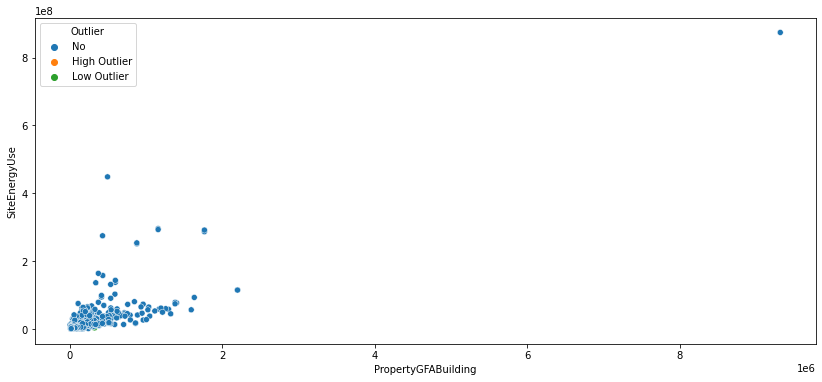

In [87]:
plt.rcParams["figure.figsize"] = (14, 6)
sns.scatterplot(x="PropertyGFABuilding", y="SiteEnergyUse", data=batiments_data, hue="Outlier")

<AxesSubplot:xlabel='PropertyGFABuilding', ylabel='SiteEnergyUse'>

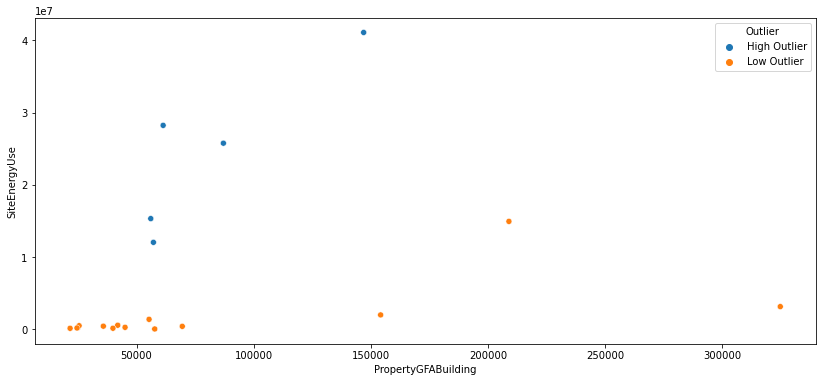

In [88]:
plt.rcParams["figure.figsize"] = (14, 6)
filtre_data = batiments_data[batiments_data.Outlier != "No"]
sns.scatterplot(x="PropertyGFABuilding", y="SiteEnergyUse", data=filtre_data, hue="Outlier")

<AxesSubplot:xlabel='PropertyGFABuilding', ylabel='SiteEnergyUse'>

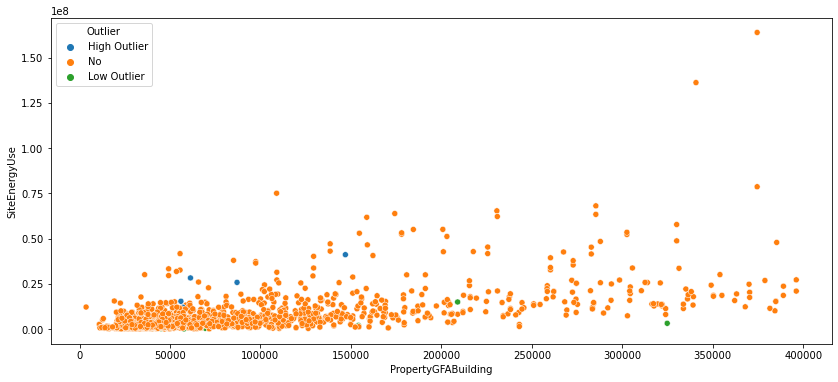

In [89]:
plt.rcParams["figure.figsize"] = (14, 6)
filtre_data = batiments_data[batiments_data.PropertyGFABuilding < 400000]
sns.scatterplot(x="PropertyGFABuilding", y="SiteEnergyUse", data=filtre_data, hue="Outlier")

La variable dépend plus de la consommation d'énergie que de la surface des bâtiments. Regardons alors de plus près avec la consommation d'énergie.

<AxesSubplot:xlabel='SiteEnergyUse', ylabel='Outlier'>

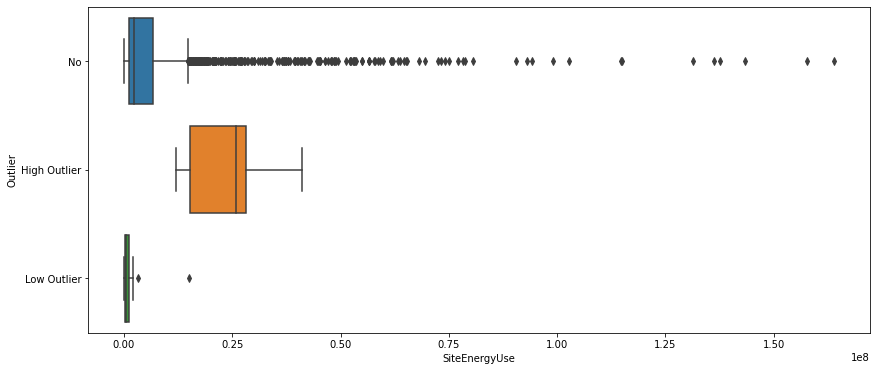

In [90]:
filtre_data = batiments_data[batiments_data.SiteEnergyUse < 200000000]
sns.boxplot(x="SiteEnergyUse", y="Outlier", data=filtre_data)

<AxesSubplot:xlabel='SiteEnergyUse', ylabel='Outlier'>

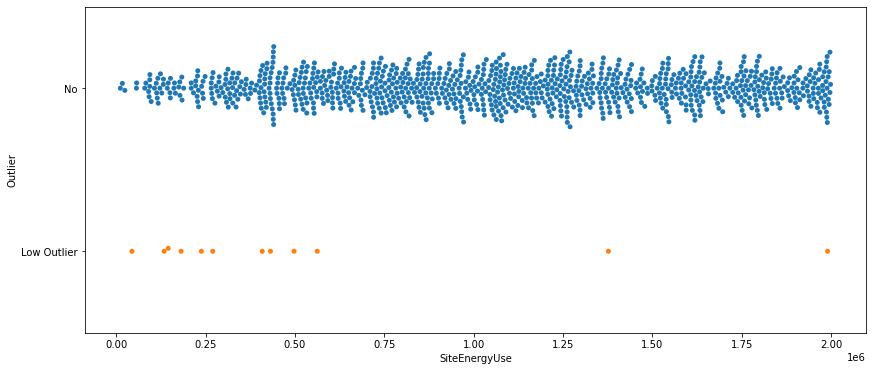

In [91]:
filtre_data = batiments_data[batiments_data.SiteEnergyUse < 2000000]
sns.swarmplot(x="SiteEnergyUse", y="Outlier", data=filtre_data)

Au vu de ces deux visualisations, certaines propriétés auraient dû se retrouver parmi les outliers en regard de leur consommation d'énergie. Je ne tire pas plus d'information utile sur cette variable des outliers, elle sera donc écartée de l'étude. 

In [255]:
batiments_data.drop(columns=["Outlier"], inplace=True)

In [256]:
batiments_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2322 entries, 0 to 2326
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   OSEBuildingID                 2322 non-null   int64  
 1   DataYear                      2322 non-null   int64  
 2   BuildingType                  2322 non-null   object 
 3   PrimaryPropertyType           2322 non-null   object 
 4   Neighborhood                  2322 non-null   object 
 5   YearBuilt                     2322 non-null   int64  
 6   NumberofBuildings             2322 non-null   float64
 7   NumberofFloors                2313 non-null   float64
 8   PropertyGFABuilding           2320 non-null   float64
 9   SecondLargestPropertyUseType  1165 non-null   object 
 10  ENERGYSTARScore               1532 non-null   float64
 11  SiteEnergyUse                 2320 non-null   float64
 12  SteamUse                      2320 non-null   float64
 13  Ele

### Données manquantes restantes

In [265]:
batiments_data.isna().sum()

OSEBuildingID                      0
DataYear                           0
BuildingType                       0
PrimaryPropertyType                0
Neighborhood                       0
YearBuilt                          0
NumberofBuildings                  0
NumberofFloors                     9
PropertyGFABuilding                2
SecondLargestPropertyUseType    1157
ENERGYSTARScore                  790
SiteEnergyUse                      2
SteamUse                           2
Electricity                        2
NaturalGas                         2
ComplianceStatus                   0
OtherFuelUse                       2
GHGEmissions                       2
Address                            0
City                               0
State                              0
ZipCode                           16
dtype: int64

Après les suppressions de certaines propriétés ci-avant, certaines d'entre elles ont encore des données manquantes. Regardons-les de plus près.

In [266]:
batiments_data[batiments_data["GHGEmissions"].isna()]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding,SecondLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse,SteamUse,Electricity,NaturalGas,ComplianceStatus,OtherFuelUse,GHGEmissions,Address,City,State,ZipCode
15,87,2015,SPS-District K-12,K-12 School,SOUTHWEST,1948,1.0,2.0,53352.0,NaN,NaN,NaN,NaN,NaN,NaN,Compliant,NaN,NaN,3701 SW 104TH ST,SEATTLE,WA,98146
497,24408,2015,SPS-District K-12,K-12 School,NORTHWEST,1953,1.0,1.0,110830.0,NaN,NaN,NaN,NaN,NaN,NaN,Compliant,NaN,NaN,1330 N 90TH ST,SEATTLE,WA,98103


In [269]:
batiments_data["BuildingType"].value_counts()

NonResidential        2039
Nonresidential COS     126
SPS-District K-12      116
Campus                  40
Nonresidential WA        1
Name: BuildingType, dtype: int64

Ces deux propriétés n'ont aucune donnée de consommation d'énergie ni d'émissions de GES. Etant donné qu'il y a un nombre important de bâtiments de type "SPS-District K-12" (116), ces propriétés seront supprimées.

In [270]:
index_batiments_consos_energie_manquantes = batiments_data[(batiments_data.GHGEmissions.isna())].index
batiments_data.drop(index=index_batiments_consos_energie_manquantes, inplace=True)

In [271]:
batiments_data[batiments_data["GHGEmissions"].isna()]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding,SecondLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse,SteamUse,Electricity,NaturalGas,ComplianceStatus,OtherFuelUse,GHGEmissions,Address,City,State,ZipCode


In [276]:
batiments_data.isna().sum()

OSEBuildingID                      0
DataYear                           0
BuildingType                       0
PrimaryPropertyType                0
Neighborhood                       0
YearBuilt                          0
NumberofBuildings                  0
NumberofFloors                     9
PropertyGFABuilding                2
SecondLargestPropertyUseType    1155
ENERGYSTARScore                  788
SiteEnergyUse                      0
SteamUse                           0
Electricity                        0
NaturalGas                         0
ComplianceStatus                   0
OtherFuelUse                       0
GHGEmissions                       0
Address                            0
City                               0
State                              0
ZipCode                           16
dtype: int64

Les valeurs manquentes du nombre d'étages et de la surface des bâtiments seront imputés.

## Analyses univariées

In [272]:
batiments_data.describe()

,OSEBuildingID,DataYear,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding,ENERGYSTARScore,SiteEnergyUse,SteamUse,Electricity,NaturalGas,OtherFuelUse,GHGEmissions
count,2320.000000,2320.000000,2320.000000,2320.000000,2311.000000,2.318000e+03,1532.000000,2.320000e+03,2.320000e+03,2.320000e+03,2.320000e+03,2.320000e+03,2320.000000
mean,16554.367672,2015.703879,1961.888793,1.179741,3.861532,1.042915e+05,64.605744,8.447904e+06,5.880510e+05,5.713087e+06,2.057848e+06,9.005559e+03,194.510530
std,13825.273121,0.456643,32.433149,2.634894,5.869567,2.590302e+05,29.144092,2.864754e+07,6.131078e+06,1.901907e+07,9.163159e+06,2.314145e+05,775.345332
min,1.000000,2015.000000,1900.000000,1.000000,0.000000,3.636000e+03,1.000000,1.144100e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.080000
25%,603.750000,2015.000000,1930.000000,1.000000,1.000000,2.850775e+04,46.000000,1.200180e+06,0.000000e+00,6.972848e+05,0.000000e+00,0.000000e+00,19.390000
50%,21210.000000,2016.000000,1966.000000,1.000000,2.000000,4.792750e+04,73.000000,2.414402e+06,0.000000e+00,1.550824e+06,4.964455e+05,0.000000e+00,48.855000
75%,24606.500000,2016.000000,1988.000000,1.000000,4.000000,9.485325e+04,89.000000,6.695685e+06,0.000000e+00,4.671698e+06,1.467290e+06,0.000000e+00,134.805000
max,50226.000000,2016.000000,2015.000000,111.000000,76.000000,9.320156e+06,100.000000,8.739237e+08,1.349435e+08,6.570744e+08,2.979090e+08,8.269669e+06,16870.980000


In [273]:
batiments_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2320 entries, 0 to 2326
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   OSEBuildingID                 2320 non-null   int64  
 1   DataYear                      2320 non-null   int64  
 2   BuildingType                  2320 non-null   object 
 3   PrimaryPropertyType           2320 non-null   object 
 4   Neighborhood                  2320 non-null   object 
 5   YearBuilt                     2320 non-null   int64  
 6   NumberofBuildings             2320 non-null   float64
 7   NumberofFloors                2311 non-null   float64
 8   PropertyGFABuilding           2318 non-null   float64
 9   SecondLargestPropertyUseType  1165 non-null   object 
 10  ENERGYSTARScore               1532 non-null   float64
 11  SiteEnergyUse                 2320 non-null   float64
 12  SteamUse                      2320 non-null   float64
 13  Ele

In [274]:
mapping_type_variables = {}
mapping_type_variables["OSEBuildingID"] = "qualitative"
mapping_type_variables["DataYear"] = "qualitative"
mapping_type_variables["BuildingType"] = "qualitative"
mapping_type_variables["PrimaryPropertyType"] = "qualitative"
mapping_type_variables["Neighborhood"] = "qualitative" 
mapping_type_variables["YearBuilt"] = "quantitative"
mapping_type_variables["NumberofBuildings"] = "quantitative"
mapping_type_variables["NumberofFloors"] = "quantitative"
mapping_type_variables["PropertyGFABuilding"] = "quantitative"
mapping_type_variables["SecondLargestPropertyUseType"] = "qualitative"
mapping_type_variables["ENERGYSTARScore"] = "quantitative"
mapping_type_variables["SiteEnergyUse"] = "quantitative"
mapping_type_variables["SteamUse"] = "quantitative"
mapping_type_variables["Electricity"] = "quantitative"
mapping_type_variables["NaturalGas"] = "quantitative"
mapping_type_variables["ComplianceStatus"] = "qualitative"
mapping_type_variables["OtherFuelUse"] = "quantitative"
mapping_type_variables["GHGEmissions"] = "quantitative"
mapping_type_variables["Address"] = "qualitative"
mapping_type_variables["City"] = "qualitative"
mapping_type_variables["State"] = "qualitative"
mapping_type_variables["ZipCode"] = "qualitative"

In [275]:
mapping_visualisation_variable = {}
mapping_visualisation_variable["OSEBuildingID"] = False
mapping_visualisation_variable["DataYear"] = True
mapping_visualisation_variable["BuildingType"] = True
mapping_visualisation_variable["PrimaryPropertyType"] = True
mapping_visualisation_variable["Neighborhood"] = True
mapping_visualisation_variable["YearBuilt"] = True
mapping_visualisation_variable["NumberofBuildings"] = True
mapping_visualisation_variable["NumberofFloors"] = True
mapping_visualisation_variable["PropertyGFABuilding"] = True
mapping_visualisation_variable["SecondLargestPropertyUseType"] = False
mapping_visualisation_variable["ENERGYSTARScore"] = True
mapping_visualisation_variable["SiteEnergyUse"] = True
mapping_visualisation_variable["SteamUse"] = True
mapping_visualisation_variable["Electricity"] = True
mapping_visualisation_variable["NaturalGas"] = True
mapping_visualisation_variable["ComplianceStatus"] = False
mapping_visualisation_variable["OtherFuelUse"] = True
mapping_visualisation_variable["GHGEmissions"] = True
mapping_visualisation_variable["Address"] = False # pas d'intérêt de visualiser cette variable
mapping_visualisation_variable["City"] = False
mapping_visualisation_variable["State"] = False
mapping_visualisation_variable["ZipCode"] = False

In [279]:
# Séparation du dataset selon les types de variables pour faciliter la visualisation
variables_quantitatives = [nom_colonne for nom_colonne in mapping_type_variables 
                                           if mapping_type_variables[nom_colonne] != "qualitative"  
                                           and mapping_visualisation_variable[nom_colonne]]
variables_qualitatives = [nom_colonne for nom_colonne in mapping_type_variables 
                                           if mapping_type_variables[nom_colonne] == "qualitative"  
                                           and mapping_visualisation_variable[nom_colonne]]
data_quanti_visualisation = batiments_data[variables_quantitatives]
data_quali_visualisation = batiments_data[variables_qualitatives]

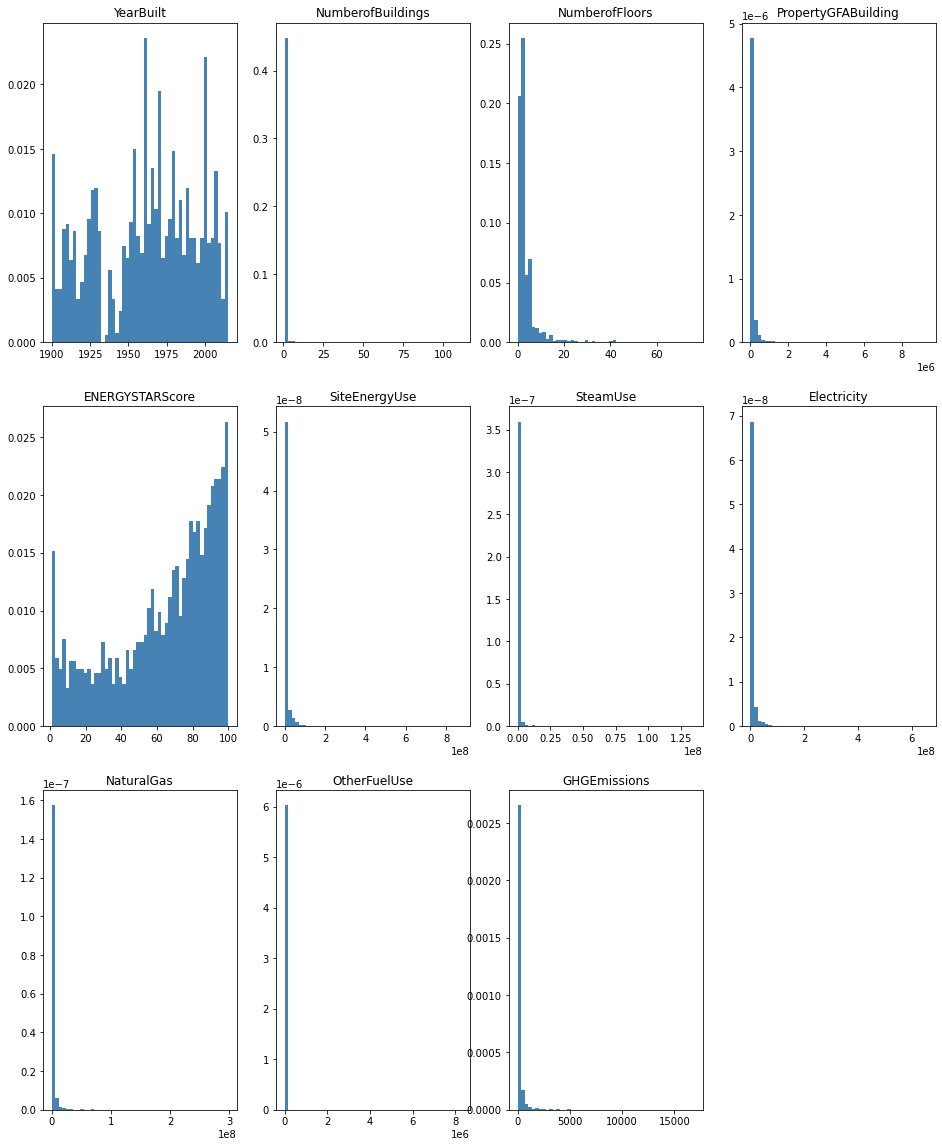

In [280]:
# Visualisation des variables quantitatives
fig = plt.figure(figsize=(16, 20))
for indice_colonne in range(data_quanti_visualisation.shape[1]):
    ax = fig.add_subplot(3, 4, (indice_colonne+1))
    nom_colonne = data_quanti_visualisation.iloc[:, indice_colonne].name
    h = ax.hist(data_quanti_visualisation.iloc[:, indice_colonne], bins=50, color='steelblue', 
                density=True, edgecolor='none')
    ax.set_title(nom_colonne, fontsize=12)

Notes : 
- le dataset contient des propriétés vieilles comme récentes.
- toutes les variables numériques sont asymétriques hormis la consommation d'autres combustibles.
- l'ordre de grandeur des variables numériques est différent selon la variable. Exemple : la consommation d'électricité varie entre 0 et 100 millions de kBtu alors que les émissions de GES varient de 0 à 15 000 $t$ $CO_{2}$ $eq$

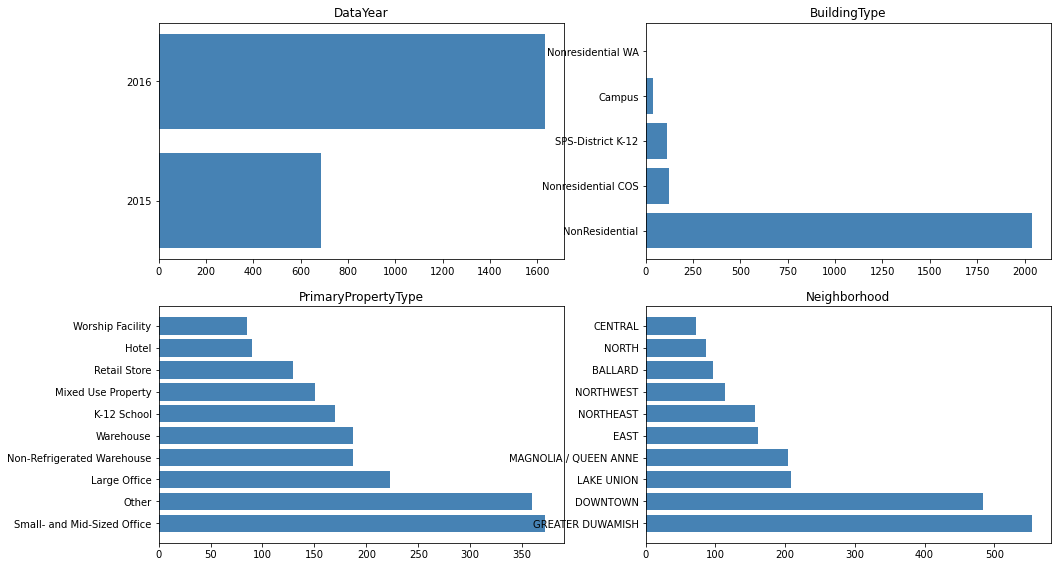

In [281]:
# Visualisation des variables qualitatives
fig = plt.figure(figsize=(16, 20))
for indice_colonne in range(data_quali_visualisation.shape[1]):
    ax = fig.add_subplot(4, 2, (indice_colonne+1))
    nom_colonne = data_quali_visualisation.iloc[:, indice_colonne].name
    stat_variable_quali = pd.DataFrame(data_quali_visualisation.iloc[:, indice_colonne].value_counts().head(10))
    bh = ax.barh(stat_variable_quali.index, stat_variable_quali[nom_colonne], tick_label=stat_variable_quali.index, 
                 color='steelblue', edgecolor='none')
    ax.set_title(nom_colonne, fontsize=12)

Les variables *PrimaryPropertyType* et *Neighborhood* présentent 10 modalités, regardons alors si elles n'en ont pas plus que cela.

In [282]:
data_quali_visualisation.loc[:, "PrimaryPropertyType"].value_counts()

Small- and Mid-Sized Office    372
Other                          359
Large Office                   223
Non-Refrigerated Warehouse     187
Warehouse                      187
K-12 School                    170
Mixed Use Property             151
Retail Store                   129
Hotel                           90
Worship Facility                85
Distribution Center             76
Medical Office                  51
Supermarket/Grocery Store       45
Self-Storage Facility           40
University                      35
Senior Care Community           29
Residence Hall                  24
Hospital                        20
Refrigerated Warehouse          16
Restaurant                      15
Laboratory                      10
Low-Rise Multifamily             3
Office                           3
Name: PrimaryPropertyType, dtype: int64

In [283]:
data_quali_visualisation.loc[:, "Neighborhood"].value_counts()

GREATER DUWAMISH         554
DOWNTOWN                 483
LAKE UNION               208
MAGNOLIA / QUEEN ANNE    204
EAST                     161
NORTHEAST                157
NORTHWEST                114
BALLARD                   97
NORTH                     86
CENTRAL                   73
DELRIDGE                  67
SOUTHEAST                 65
SOUTHWEST                 51
Name: Neighborhood, dtype: int64

## Analyses multivariées

### Variables quantitatives

In [284]:
batiments_data.describe()

,OSEBuildingID,DataYear,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding,ENERGYSTARScore,SiteEnergyUse,SteamUse,Electricity,NaturalGas,OtherFuelUse,GHGEmissions
count,2320.000000,2320.000000,2320.000000,2320.000000,2311.000000,2.318000e+03,1532.000000,2.320000e+03,2.320000e+03,2.320000e+03,2.320000e+03,2.320000e+03,2320.000000
mean,16554.367672,2015.703879,1961.888793,1.179741,3.861532,1.042915e+05,64.605744,8.447904e+06,5.880510e+05,5.713087e+06,2.057848e+06,9.005559e+03,194.510530
std,13825.273121,0.456643,32.433149,2.634894,5.869567,2.590302e+05,29.144092,2.864754e+07,6.131078e+06,1.901907e+07,9.163159e+06,2.314145e+05,775.345332
min,1.000000,2015.000000,1900.000000,1.000000,0.000000,3.636000e+03,1.000000,1.144100e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.080000
25%,603.750000,2015.000000,1930.000000,1.000000,1.000000,2.850775e+04,46.000000,1.200180e+06,0.000000e+00,6.972848e+05,0.000000e+00,0.000000e+00,19.390000
50%,21210.000000,2016.000000,1966.000000,1.000000,2.000000,4.792750e+04,73.000000,2.414402e+06,0.000000e+00,1.550824e+06,4.964455e+05,0.000000e+00,48.855000
75%,24606.500000,2016.000000,1988.000000,1.000000,4.000000,9.485325e+04,89.000000,6.695685e+06,0.000000e+00,4.671698e+06,1.467290e+06,0.000000e+00,134.805000
max,50226.000000,2016.000000,2015.000000,111.000000,76.000000,9.320156e+06,100.000000,8.739237e+08,1.349435e+08,6.570744e+08,2.979090e+08,8.269669e+06,16870.980000


<AxesSubplot:>

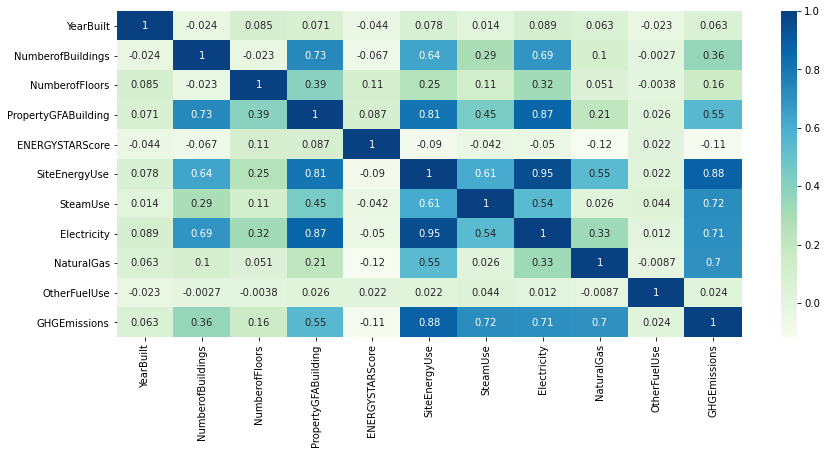

In [285]:
plt.rcParams["figure.figsize"] = (14, 6)
correlations = data_quanti_visualisation.corr()
sns.heatmap(correlations, cmap="GnBu", annot=True)

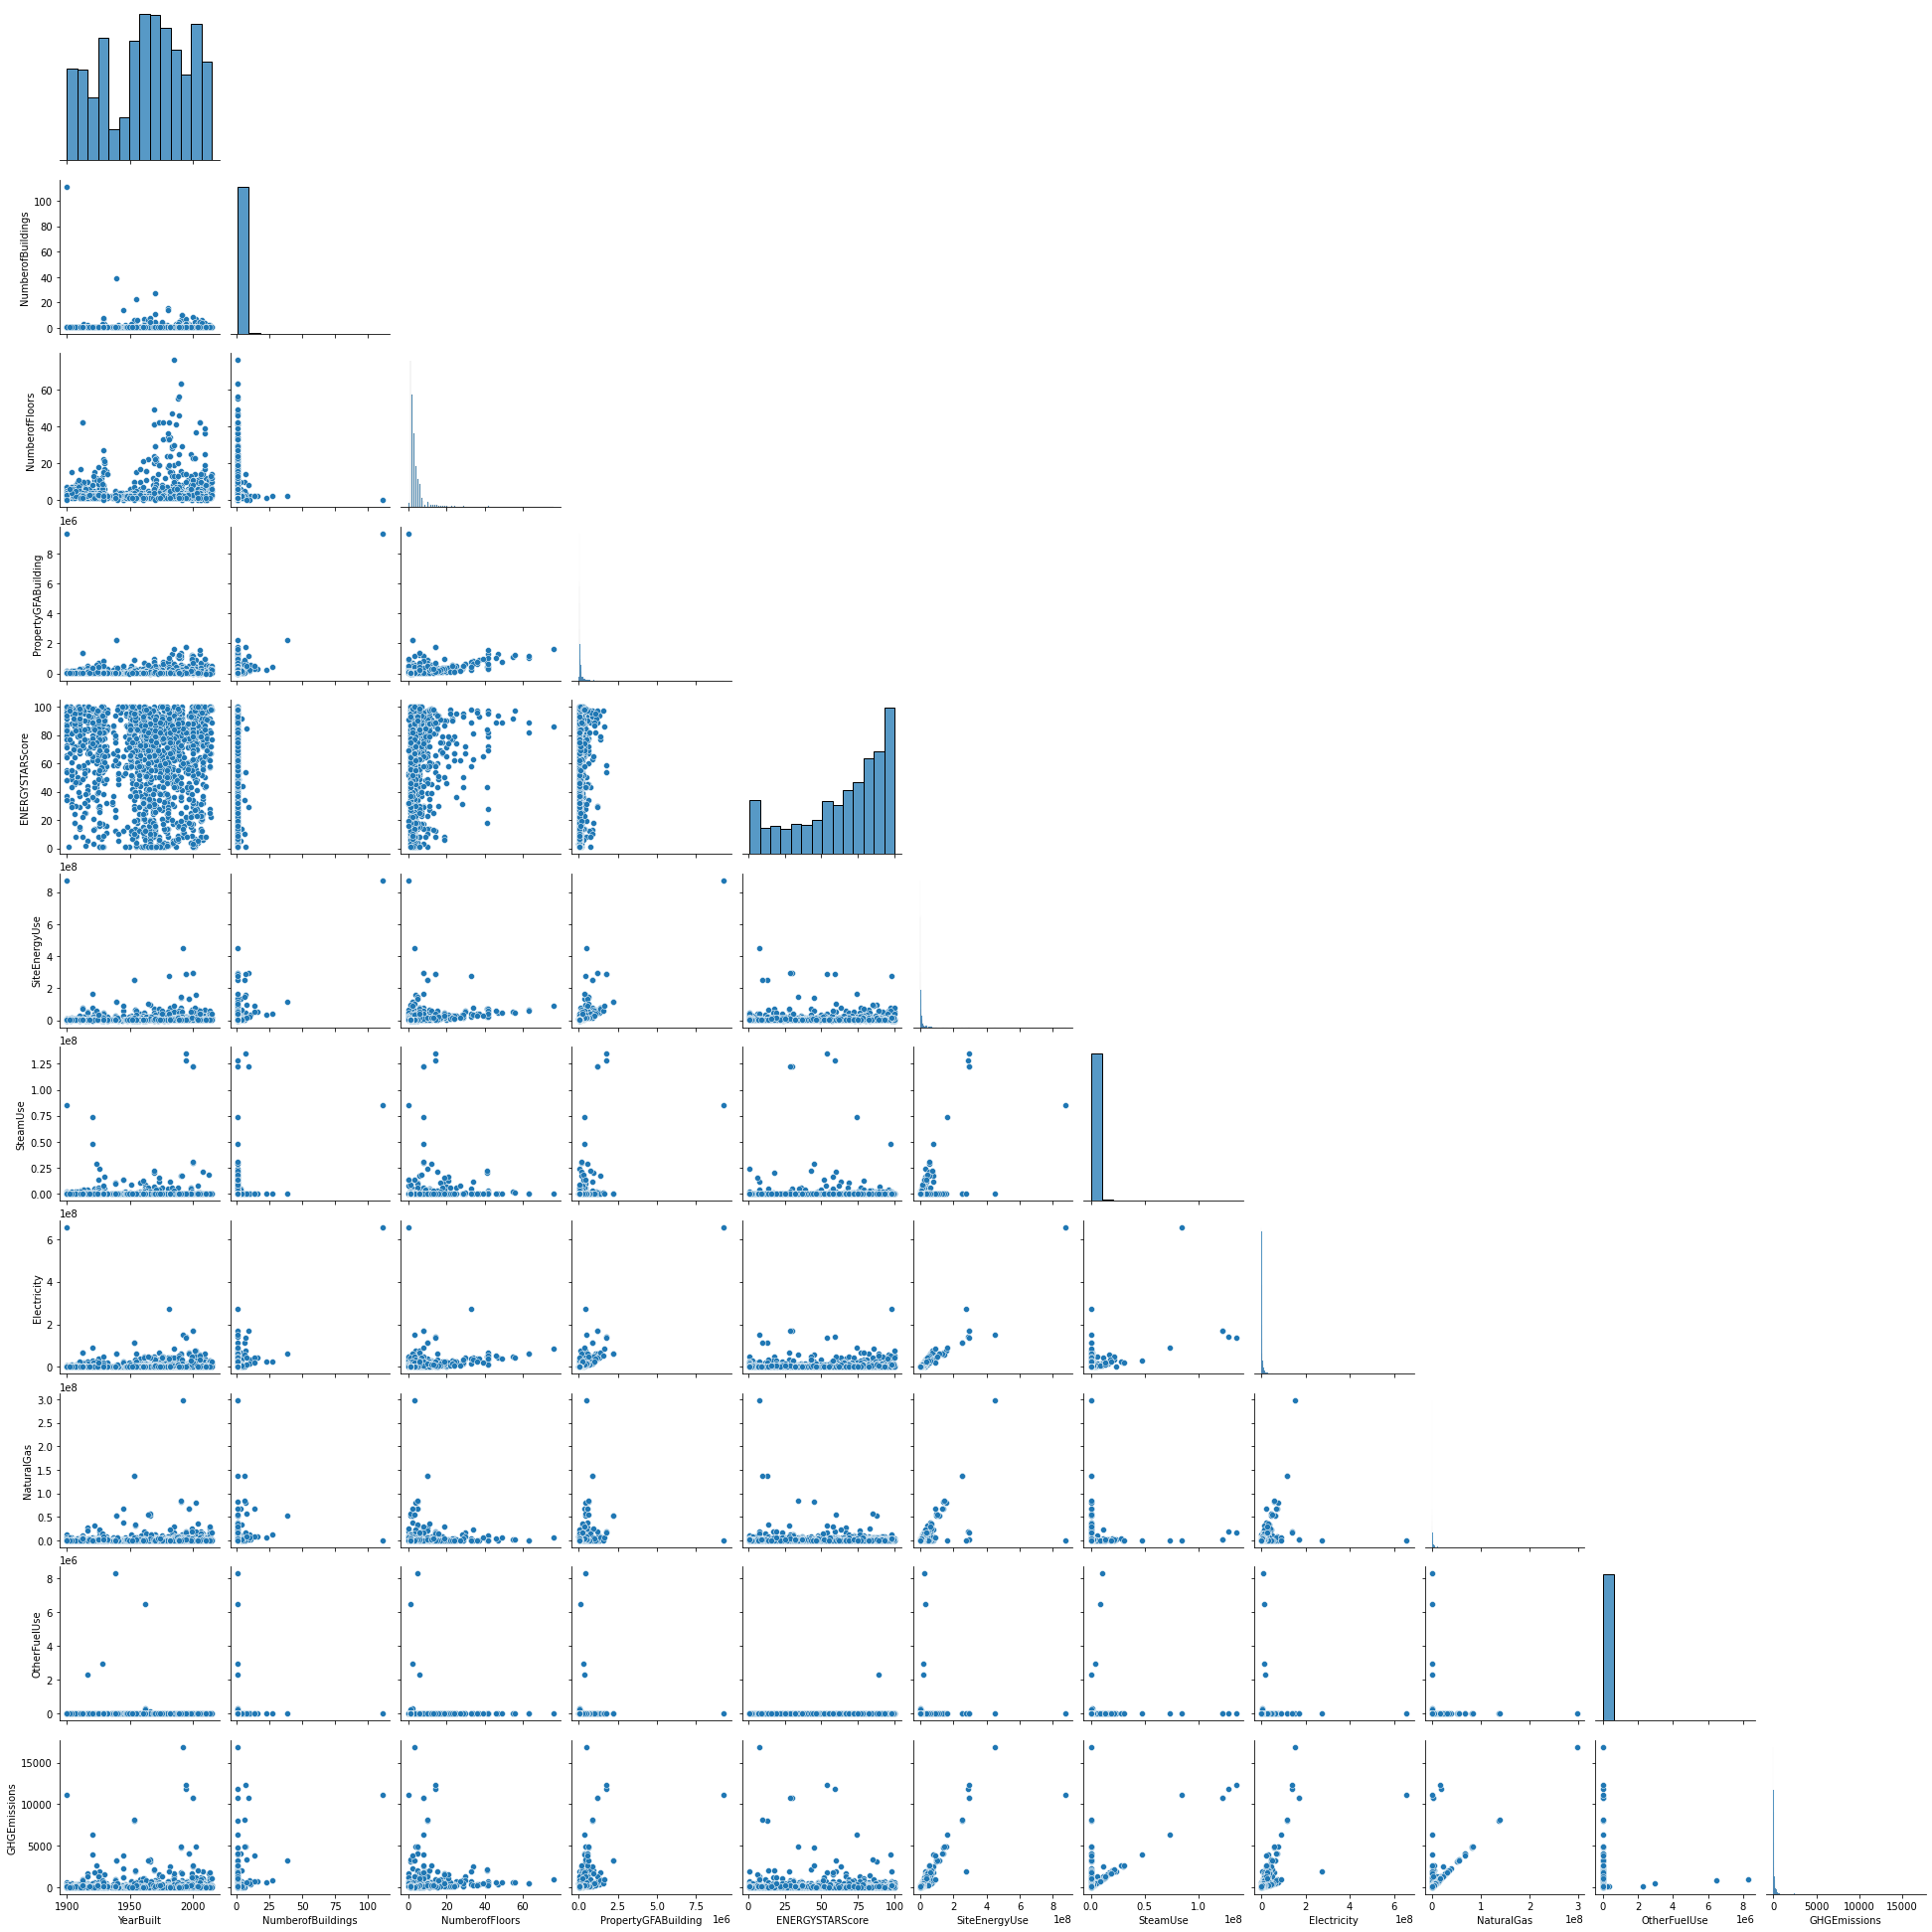

In [286]:
sns.pairplot(data_quanti_visualisation, height=2.5, corner=True)

On observe les corrélations linéaires suivantes entre :
- la consommation d'énergie totale avec la consommation de vapeur, d'électricité et de gaz ainsi que les émissions de GES. Concernant la consommation de vapeur et de gaz, la corrélation est visible s'il y a une consommation effective de ces énergies.
- la consommation de vapeur et celle d'électricité s'il y a une consommation effective de vapeur
- les émissions de GES avec la consommation totale d'énergie et la consommation une à une de vapeur, d'électricité et de gaz.
- **la consommation totale d'énergie avec le nombre de bâtiments (légère corrélation) et avec la surface de la propriété.**

### Variables qualitatives

In [287]:
data_quali_visualisation

,DataYear,BuildingType,PrimaryPropertyType,Neighborhood
0,2015,NonResidential,Hotel,DOWNTOWN
1,2015,NonResidential,Hotel,DOWNTOWN
2,2015,NonResidential,Hotel,DOWNTOWN
3,2015,NonResidential,Hotel,DOWNTOWN
4,2015,NonResidential,Hotel,DOWNTOWN
...,...,...,...,...
2322,2016,Nonresidential COS,Office,GREATER DUWAMISH
2323,2016,Nonresidential COS,Other,DOWNTOWN
2324,2016,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE
2325,2016,Nonresidential COS,Mixed Use Property,GREATER DUWAMISH


#### Usage principal de la propriété et quartier

<AxesSubplot:xlabel='PrimaryPropertyType', ylabel='count'>

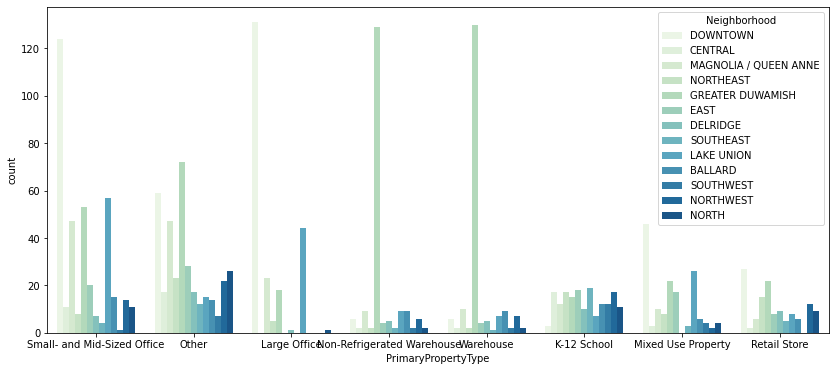

In [288]:
plt.rcParams["figure.figsize"] = (14, 6)
sns.countplot(data = data_quali_visualisation, x="PrimaryPropertyType", hue="Neighborhood", palette = 'GnBu', 
              order=data_quali_visualisation["PrimaryPropertyType"].value_counts().iloc[:8].index,
             )

<AxesSubplot:xlabel='PrimaryPropertyType', ylabel='count'>

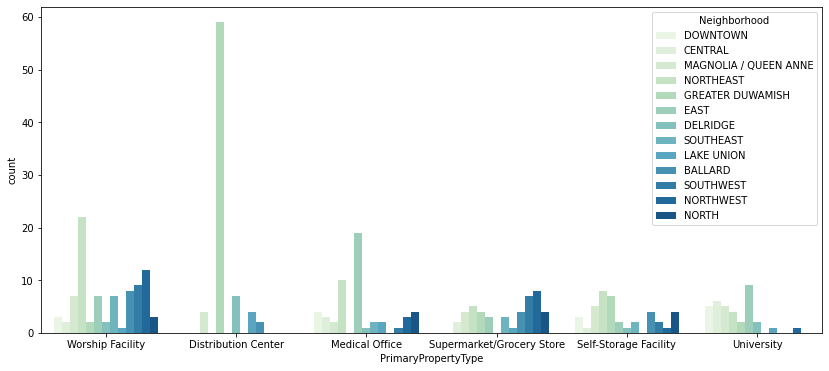

In [289]:
plt.rcParams["figure.figsize"] = (14, 6)
sns.countplot(data = data_quali_visualisation, x="PrimaryPropertyType", hue="Neighborhood", palette = 'GnBu', 
              order=data_quali_visualisation["PrimaryPropertyType"].value_counts().iloc[9:15].index,
             )

<AxesSubplot:xlabel='PrimaryPropertyType', ylabel='count'>

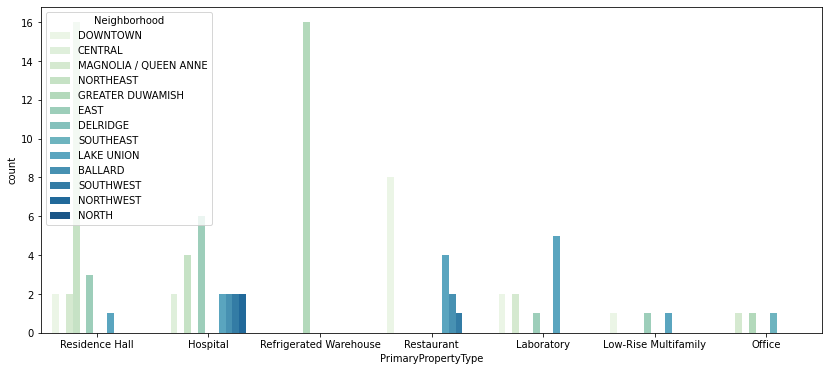

In [290]:
plt.rcParams["figure.figsize"] = (14, 6)
sns.countplot(data = data_quali_visualisation, x="PrimaryPropertyType", hue="Neighborhood", palette = 'GnBu', 
              order=data_quali_visualisation["PrimaryPropertyType"].value_counts().iloc[16:].index,
             )

On observe une dépendance entre l'usage principale de la propriété et le quartier où elle se trouve. En effet, certains types de propriétés se concentrent plus dans certains quartiers de Seattle. Par exemple, les restaurants se trouvent principalement dans le centre et la partie Nord de la ville. Alors que pour les entrepôts (tout type confondu) sont majoritairement situés dans le Great Duwamish.

### Variables quantitatives et qualitatives

In [291]:
data_quali_visualisation = data_quali_visualisation.drop(columns=["DataYear"])
data_quanti_visualisation = data_quanti_visualisation.drop(columns=["YearBuilt"])

<ipython-input-292-1e916a31933a>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(14, 6))


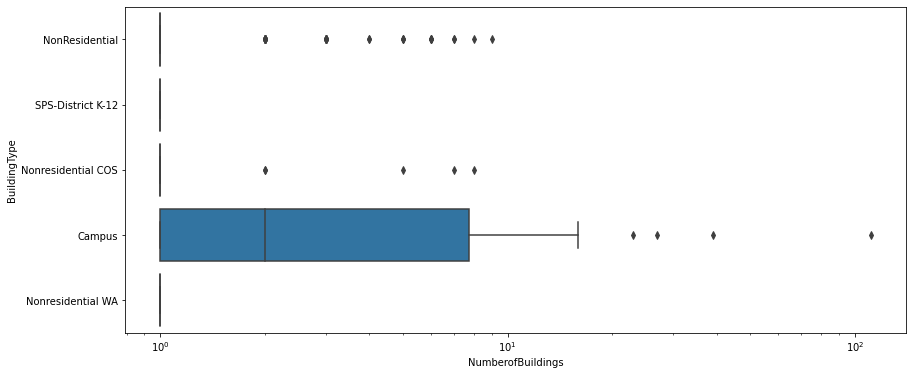

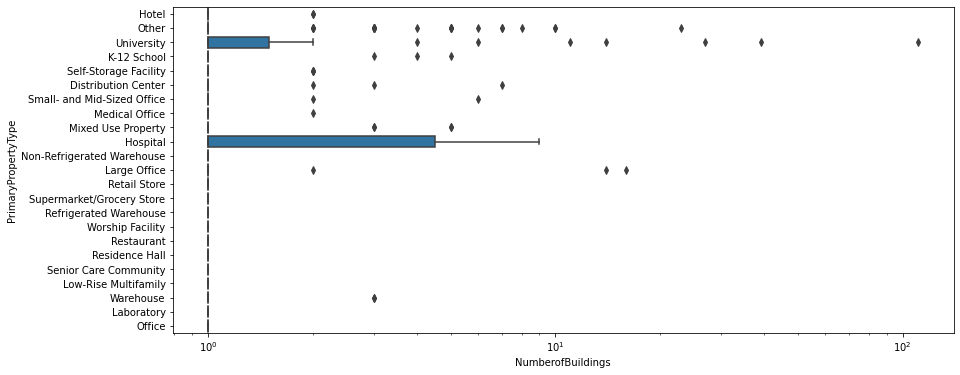

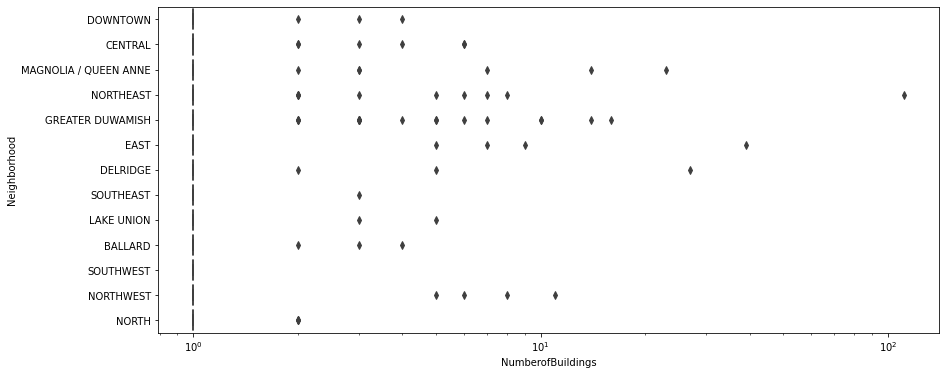

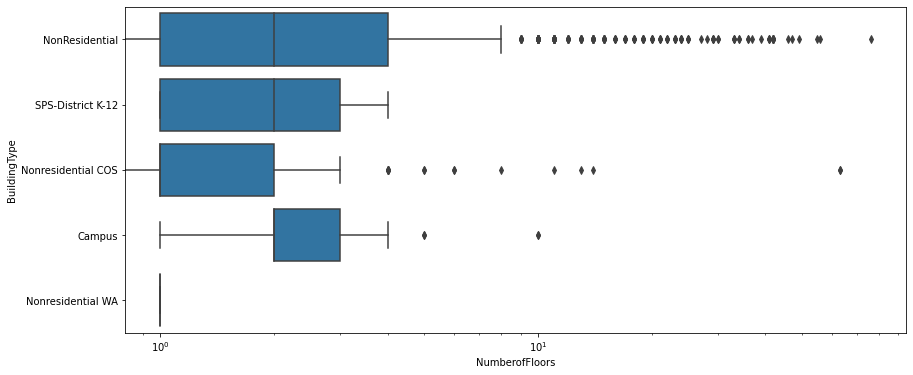

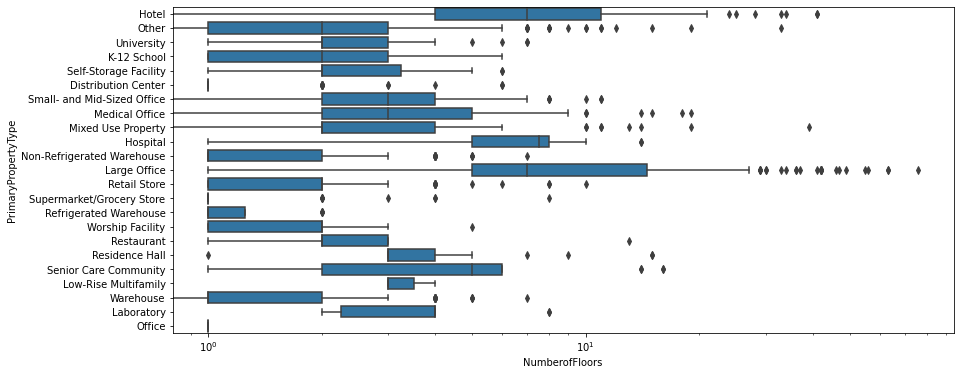

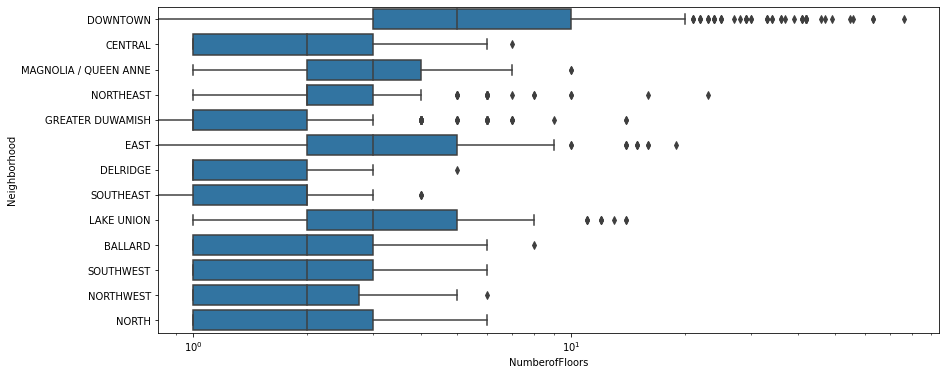

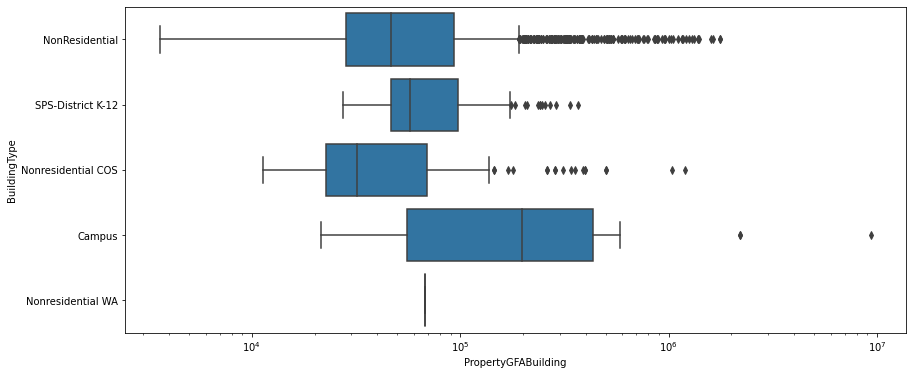

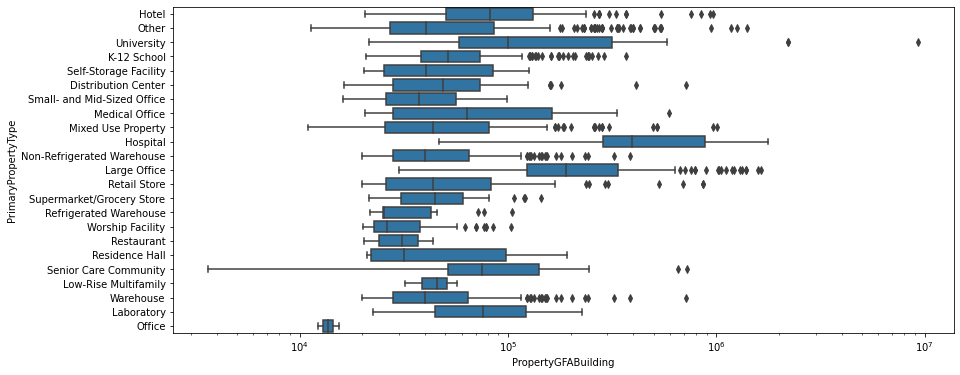

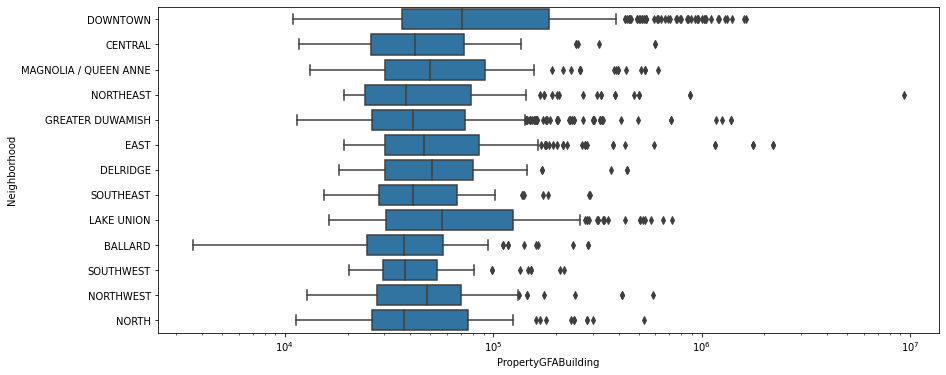

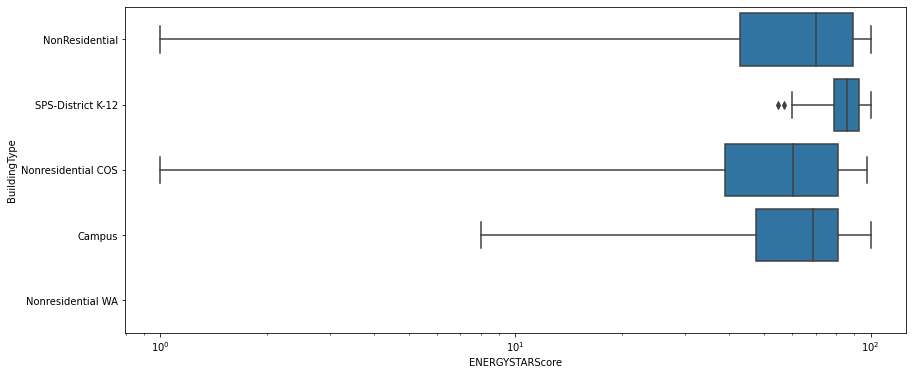

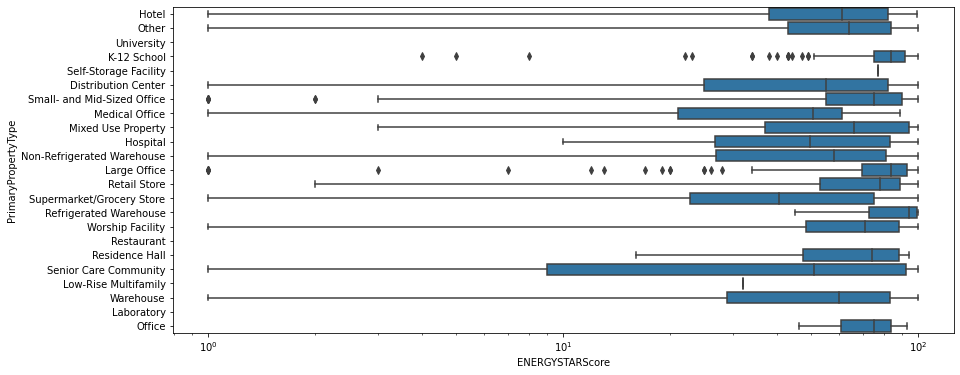

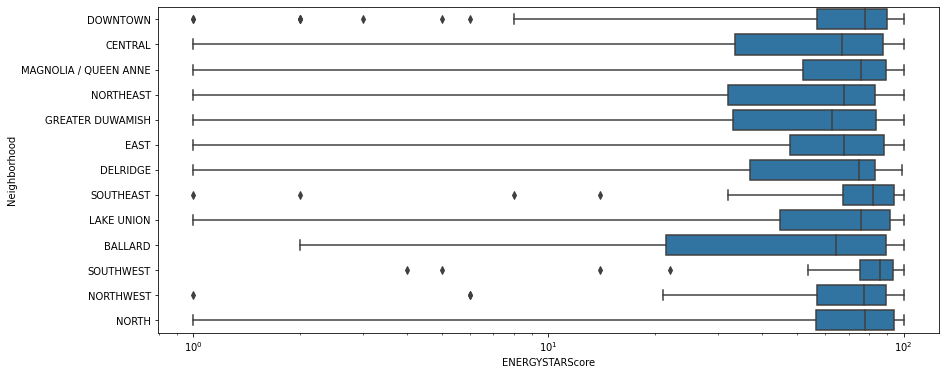

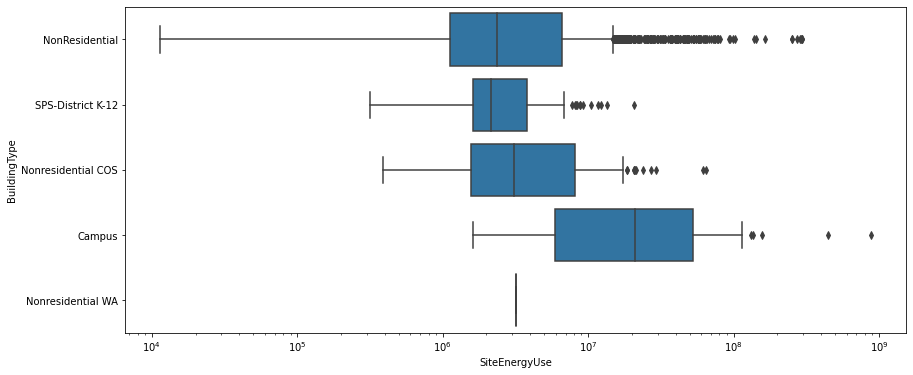

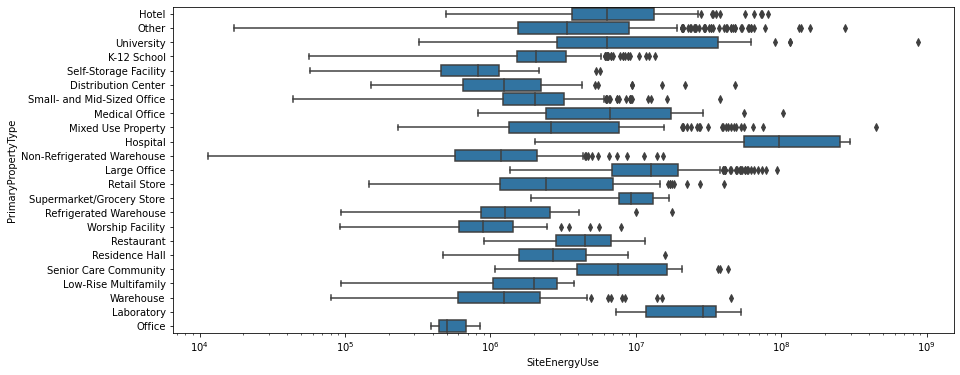

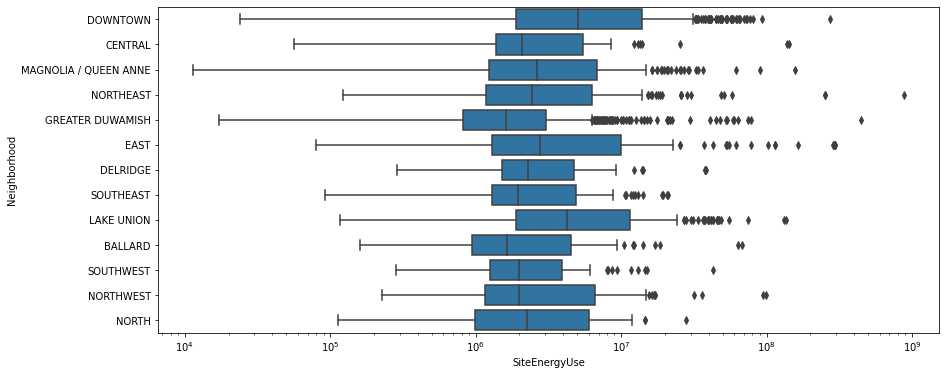

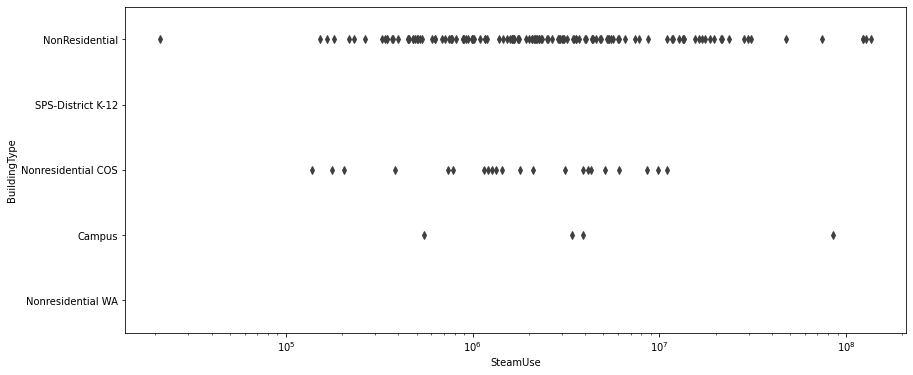

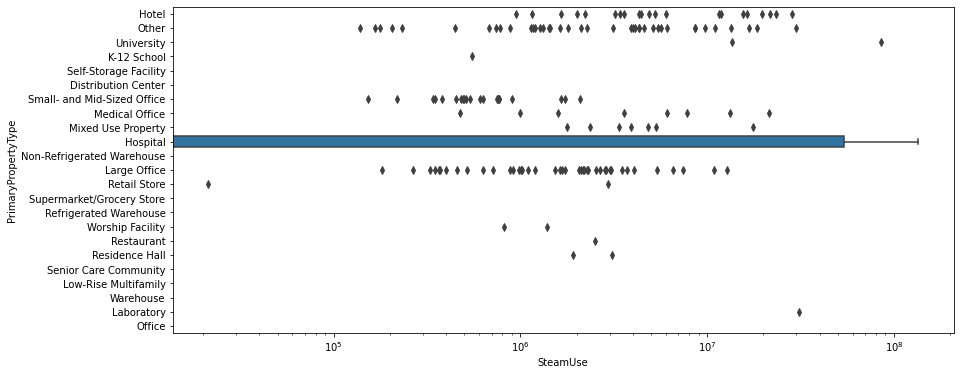

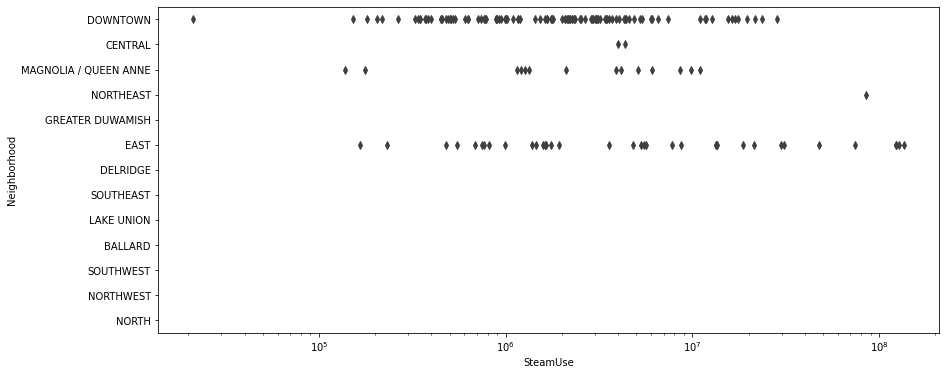

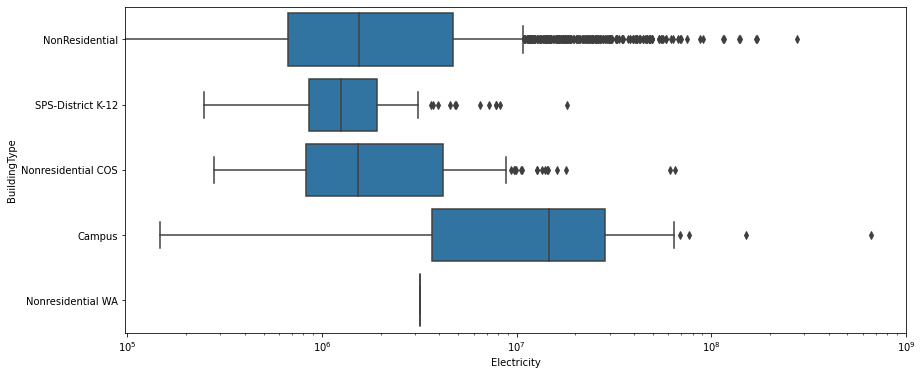

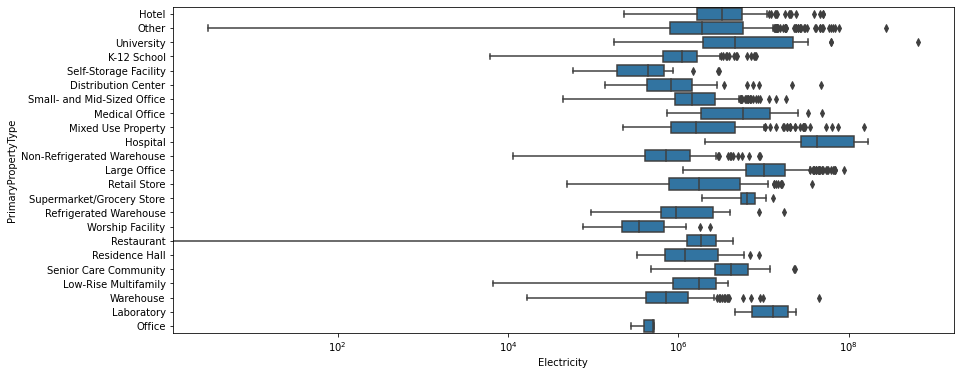

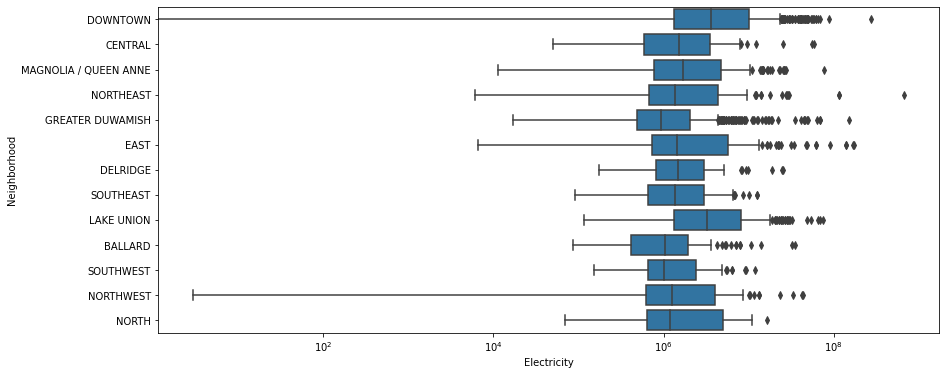

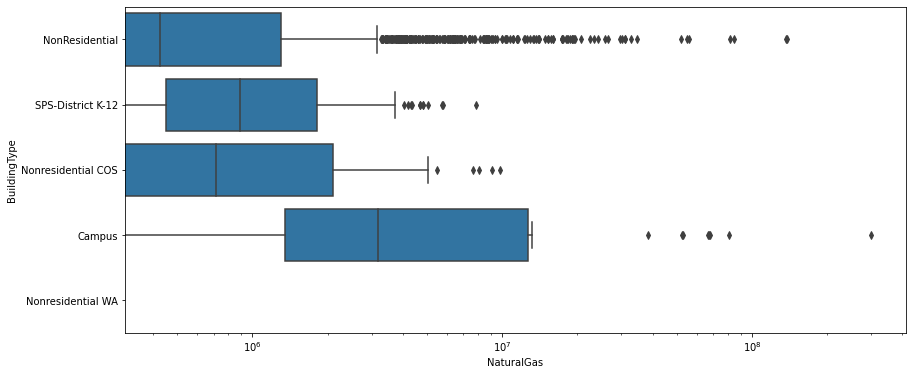

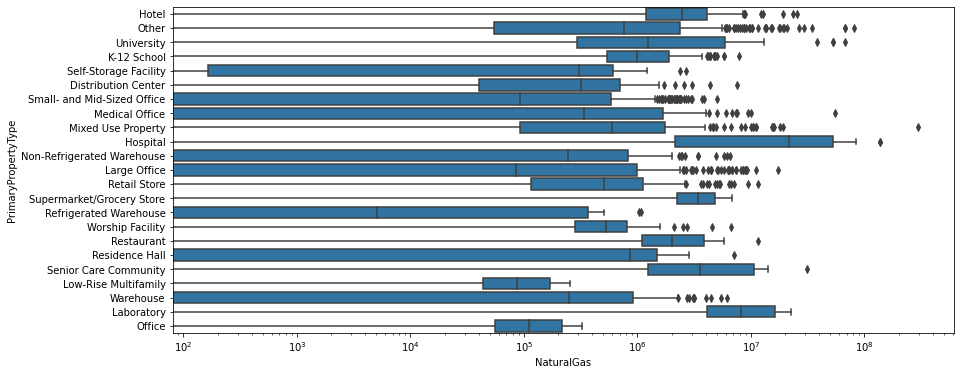

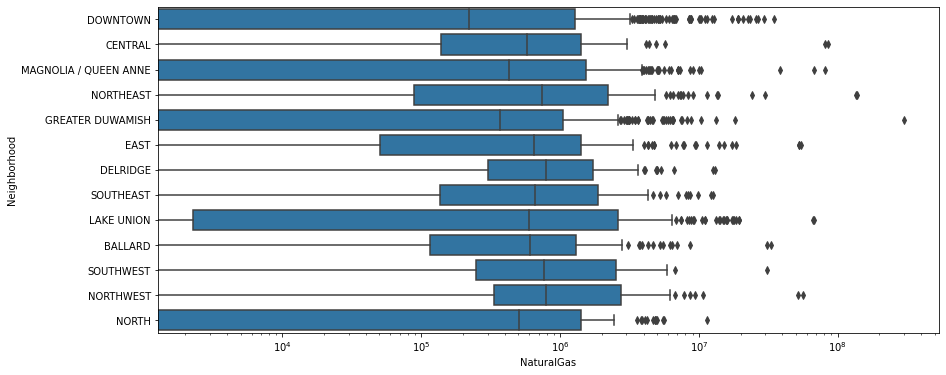

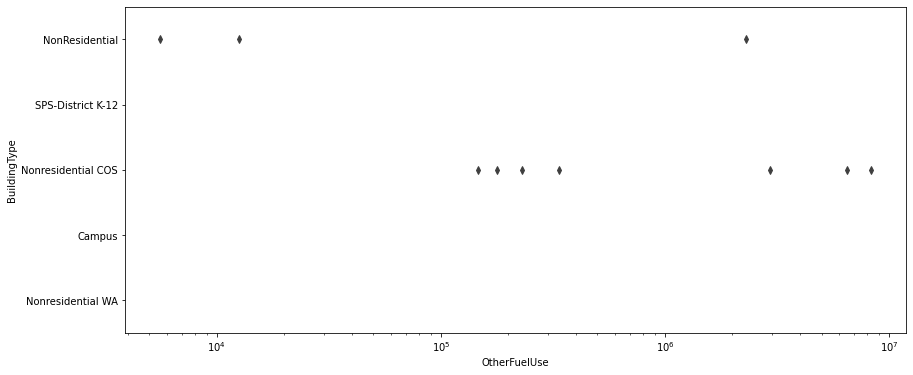

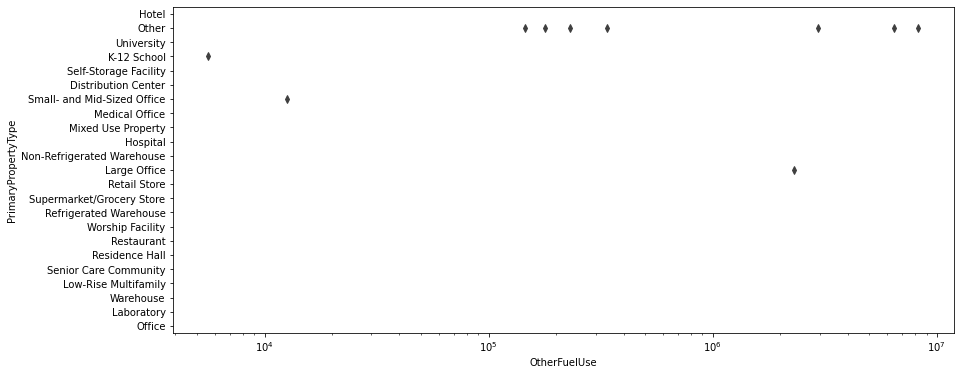

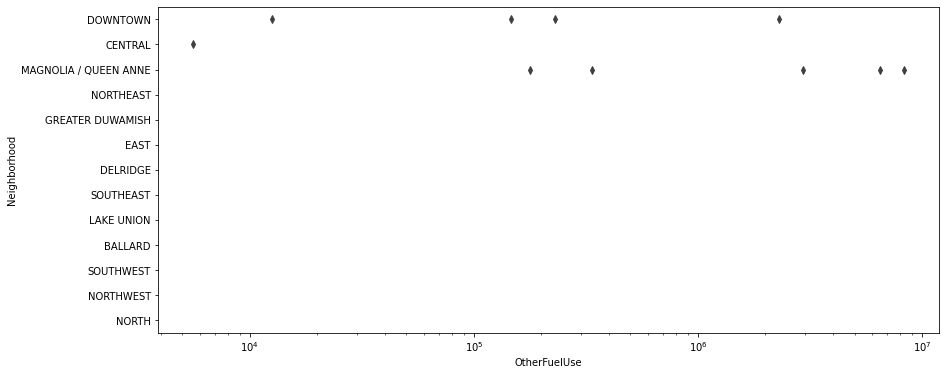

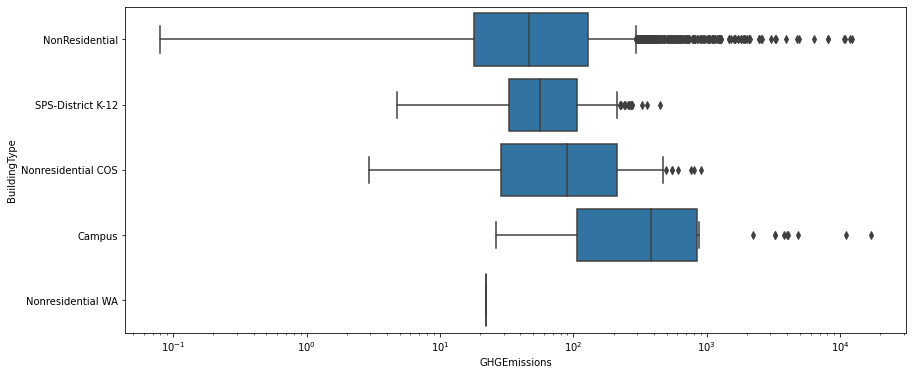

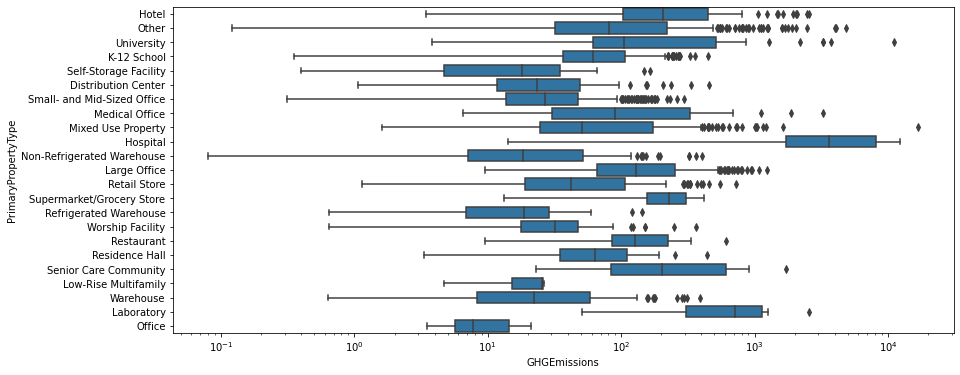

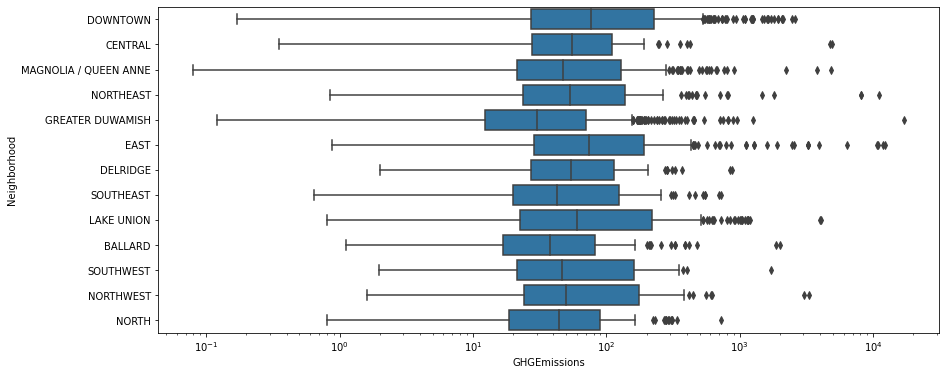

In [292]:
for quanti_nom_colonne in data_quanti_visualisation.columns:
    for quali_nom_colonne in data_quali_visualisation.columns:
        plt.figure(figsize=(14, 6))
        b = sns.boxplot(x=quanti_nom_colonne, y=quali_nom_colonne, data=batiments_data, color='tab:blue')
        b.set(xscale="log")

On peut voir que le type de la propriété et son usage principal ont une dépendance forte avec beaucoup de variables quantitatives comme la consommation d'énergie et les émissions de GES. Effectivement, les hôpitaux et les laboratoires ont une consommation d'énergie bien plus élevée que les autres usages principaux de propriété.

# Imputation des données

In [263]:
batiments_data.isna().sum()

OSEBuildingID                      0
DataYear                           0
BuildingType                       0
PrimaryPropertyType                0
Neighborhood                       0
YearBuilt                          0
NumberofBuildings                  0
NumberofFloors                     9
PropertyGFABuilding                2
SecondLargestPropertyUseType    1157
ENERGYSTARScore                  790
SiteEnergyUse                      2
SteamUse                           2
Electricity                        2
NaturalGas                         2
ComplianceStatus                   0
OtherFuelUse                       2
GHGEmissions                       2
Address                            0
City                               0
State                              0
ZipCode                           16
dtype: int64

Les variables *SecondLargestPropertyUseType*, *ENERGYSTARScore* et *ZipCode* ne me serviront pas à contruire mes modèles. *Outlier* a été supprimé du dataset. Je me retrouve uniquement avec des variables ayant moins de 10 valeurs manquantes. J'imputerai *NumberofFloors* avec le mode et les autres variables continues avec leur médiane car ces variables sont asymétriques.

In [262]:
batiments_data[batiments_data["GHGEmissions"].isnull()]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding,SecondLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse,SteamUse,Electricity,NaturalGas,ComplianceStatus,OtherFuelUse,GHGEmissions,Address,City,State,ZipCode
15,87,2015,SPS-District K-12,K-12 School,SOUTHWEST,1948,1.0,2.0,53352.0,NaN,NaN,NaN,NaN,NaN,NaN,Compliant,NaN,NaN,3701 SW 104TH ST,SEATTLE,WA,98146
497,24408,2015,SPS-District K-12,K-12 School,NORTHWEST,1953,1.0,1.0,110830.0,NaN,NaN,NaN,NaN,NaN,NaN,Compliant,NaN,NaN,1330 N 90TH ST,SEATTLE,WA,98103


## *NumberofFloors*

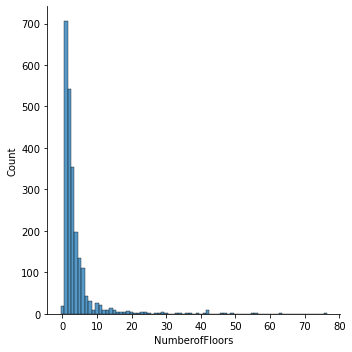

In [96]:
sns.displot(batiments_data, x="NumberofFloors", discrete=True)

In [165]:
batiments_data["NumberofFloors"].fillna(batiments_data["NumberofFloors"].mode()[0], inplace=True)

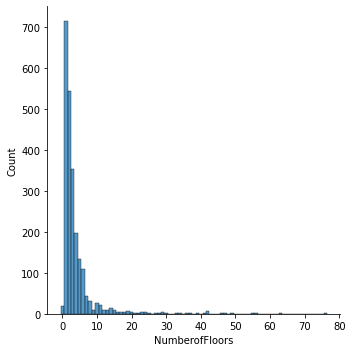

In [113]:
sns.displot(batiments_data, x="NumberofFloors", discrete=True)

## *SiteEnergyUse*

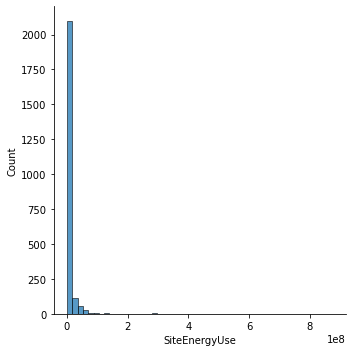

In [118]:
sns.displot(batiments_data, x="SiteEnergyUse", bins=50)

In [166]:
batiments_data["SiteEnergyUse"].fillna(batiments_data["SiteEnergyUse"].median(), inplace=True)

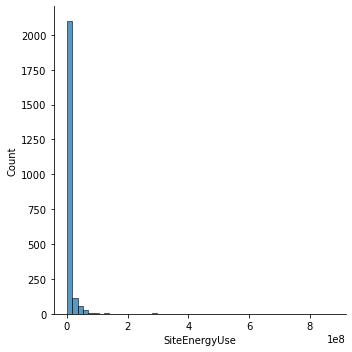

In [121]:
sns.displot(batiments_data, x="SiteEnergyUse", bins=50)

## *PropertyGFABuilding*

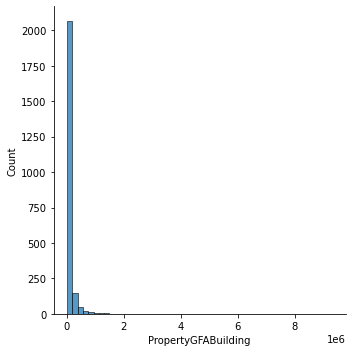

In [123]:
sns.displot(batiments_data, x="PropertyGFABuilding", bins=50)

In [167]:
batiments_data["PropertyGFABuilding"].fillna(batiments_data["PropertyGFABuilding"].median(), inplace=True)

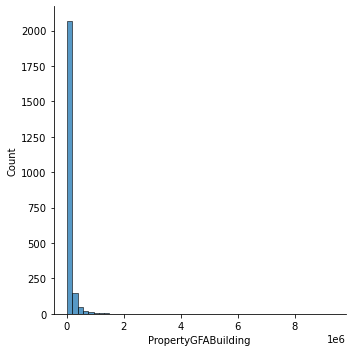

In [125]:
sns.displot(batiments_data, x="PropertyGFABuilding", bins=50)

## *SteamUse*

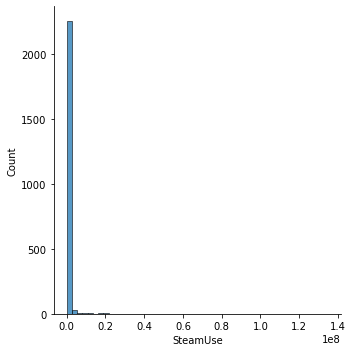

In [127]:
sns.displot(batiments_data, x="SteamUse", bins=50)

In [168]:
batiments_data["SteamUse"].fillna(batiments_data["SteamUse"].median(), inplace=True)

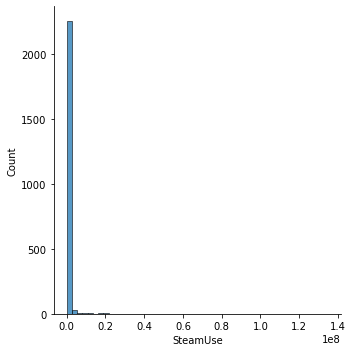

In [129]:
sns.displot(batiments_data, x="SteamUse", bins=50)

## *Electricity*

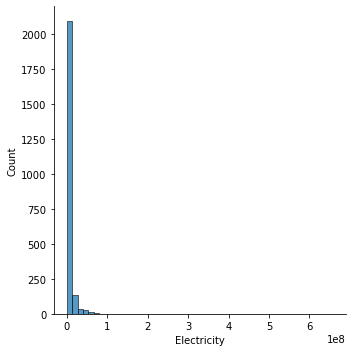

In [132]:
sns.displot(batiments_data, x="Electricity", bins=50)

In [169]:
batiments_data["Electricity"].fillna(batiments_data["Electricity"].median(), inplace=True)

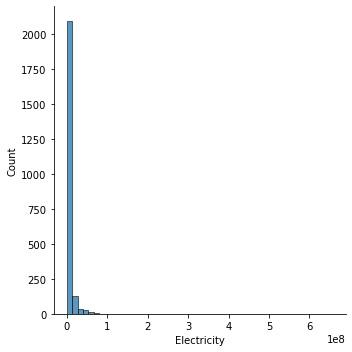

In [134]:
sns.displot(batiments_data, x="Electricity", bins=50)

## *NaturalGas*

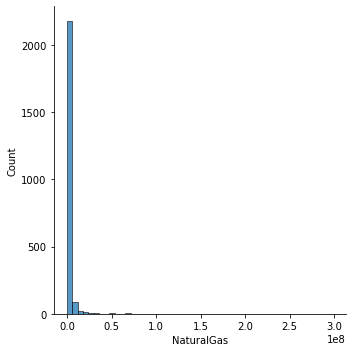

In [137]:
sns.displot(batiments_data, x="NaturalGas", bins=50)

In [170]:
batiments_data["NaturalGas"].fillna(batiments_data["NaturalGas"].median(), inplace=True)

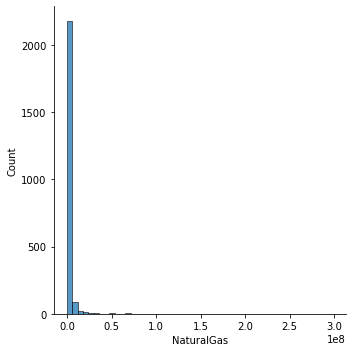

In [139]:
sns.displot(batiments_data, x="NaturalGas", bins=50)

## *OtherFuelUse*

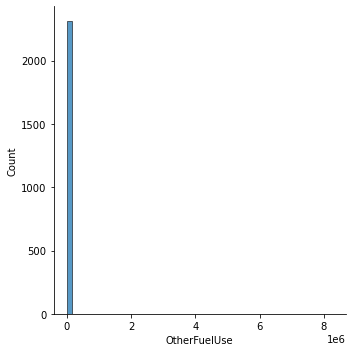

In [141]:
sns.displot(batiments_data, x="OtherFuelUse", bins=50)

In [171]:
batiments_data["OtherFuelUse"].fillna(batiments_data["OtherFuelUse"].median(), inplace=True)

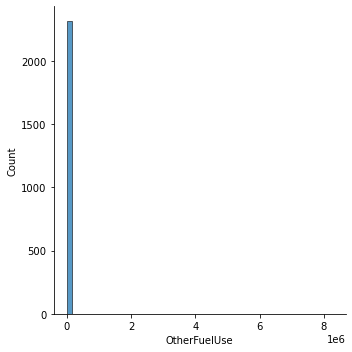

In [143]:
sns.displot(batiments_data, x="OtherFuelUse", bins=50)

## *GHGEmissions*

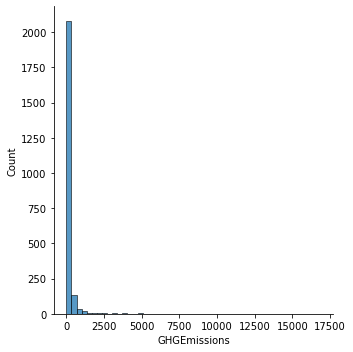

In [145]:
sns.displot(batiments_data, x="GHGEmissions", bins=50)

In [172]:
batiments_data["GHGEmissions"].fillna(batiments_data["GHGEmissions"].median(), inplace=True)

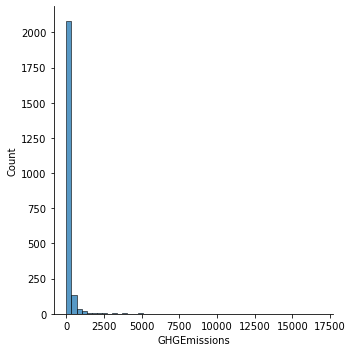

In [147]:
sns.displot(batiments_data, x="GHGEmissions", bins=50)

In [173]:
batiments_data.isna().sum()

OSEBuildingID                      0
DataYear                           0
BuildingType                       0
PrimaryPropertyType                0
Neighborhood                       0
YearBuilt                          0
NumberofBuildings                  0
NumberofFloors                     0
PropertyGFABuilding                0
SecondLargestPropertyUseType    1157
ENERGYSTARScore                  790
SiteEnergyUse                      0
SteamUse                           0
Electricity                        0
NaturalGas                         0
ComplianceStatus                   0
OtherFuelUse                       0
GHGEmissions                       0
Address                            0
City                               0
State                              0
ZipCode                           16
dtype: int64

# Features engineering

In [149]:
batiments_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2322 entries, 0 to 2326
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   OSEBuildingID                 2322 non-null   int64  
 1   DataYear                      2322 non-null   int64  
 2   BuildingType                  2322 non-null   object 
 3   PrimaryPropertyType           2322 non-null   object 
 4   Neighborhood                  2322 non-null   object 
 5   YearBuilt                     2322 non-null   int64  
 6   NumberofBuildings             2322 non-null   float64
 7   NumberofFloors                2322 non-null   float64
 8   PropertyGFABuilding           2322 non-null   float64
 9   SecondLargestPropertyUseType  1165 non-null   object 
 10  ENERGYSTARScore               1532 non-null   float64
 11  SiteEnergyUse                 2322 non-null   float64
 12  SteamUse                      2322 non-null   float64
 13  Ele

In [89]:
pd.set_option("display.max_columns", None)
batiments_data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding,SecondLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse,SteamUse,Electricity,NaturalGas,ComplianceStatus,OtherFuelUse,GHGEmissions,Address,City,State,ZipCode,BuildingAge
0,3,2015,NonResidential,Hotel,DOWNTOWN,1969,1.0,41.0,961990.0,Parking,18.0,73130656.0,19660404.0,49762435.0,3709900.0,Compliant,0.0,2061.48,1900 5TH AVE,SEATTLE,WA,98101,46
1,5,2015,NonResidential,Hotel,DOWNTOWN,1926,1.0,10.0,61320.0,NaN,1.0,28229320.0,23458518.0,2769023.0,2001894.0,Compliant,0.0,1936.34,620 STEWART ST,SEATTLE,WA,98101,89
2,8,2015,NonResidential,Hotel,DOWNTOWN,1980,1.0,18.0,107430.0,Parking,67.0,14829099.0,0.0,6066245.0,8763105.0,Compliant,0.0,507.70,401 LENORA ST,SEATTLE,WA,98121,35
3,19,2015,NonResidential,Hotel,DOWNTOWN,1922,1.0,11.0,67390.0,NaN,14.0,10711451.0,4403788.0,4089407.0,2218425.0,Compliant,0.0,486.25,1100 5TH AVE,SEATTLE,WA,98101,93
4,25,2015,NonResidential,Hotel,DOWNTOWN,1916,1.0,10.0,104352.0,NaN,83.0,7845112.0,3205497.0,1790665.0,2849024.0,Compliant,0.0,411.22,700 3RD AVE,SEATTLE,WA,98104,99


## Création de l'âge du bâtiment en années

In [174]:
batiments_data["BuildingAge"] = batiments_data["DataYear"] - batiments_data["YearBuilt"]

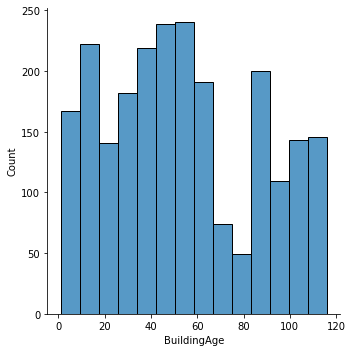

In [95]:
sns.displot(batiments_data, x="BuildingAge")

## Les consommations d'énergies

Etant donné que je souhaite prédire la consommation d'énergie totale et les émissions de GES sans les relevés de consommation. Je ne peux pas construire mes modèles avec les données relatives à la consommation d'électricité, de vapeur, de gaz et d'autres combustibles. En effet, je risque un data leakage.

A la construction d'un bâtiment, on sait quelles énergies il consommera et son mix énergétique. De ce fait, je vais construire un top pour chaque énergie, créer une variable qui compte le nombre d'énergies différentes utilisées et une autre qui recense l'énergie la plus consommée.

### Top pour chaque énergie utilisée

In [175]:
# Consommation de vapeur
batiments_data.loc[batiments_data["SteamUse"] > 0, "IsSteamUser"] = 1
batiments_data.loc[batiments_data["SteamUse"] == 0, "IsSteamUser"] = 0

# Consommation d'électricité
batiments_data.loc[batiments_data["Electricity"] > 0, "IsElectricityUser"] = 1
batiments_data.loc[batiments_data["Electricity"] == 0, "IsElectricityUser"] = 0

# Consommation de gaz
batiments_data.loc[batiments_data["NaturalGas"] > 0, "IsNaturalGasUser"] = 1
batiments_data.loc[batiments_data["NaturalGas"] == 0, "IsNaturalGasUser"] = 0

# Consommation d'autres combustibles
batiments_data.loc[batiments_data["OtherFuelUse"] > 0, "IsOtherFuelUser"] = 1
batiments_data.loc[batiments_data["OtherFuelUse"] == 0, "IsOtherFuelUser"] = 0

### Nombre d'énergies différentes utilisées

In [176]:
batiments_data["NumberOfUsedEnergies"] = batiments_data["IsSteamUser"] + batiments_data["IsElectricityUser"] + batiments_data["IsNaturalGasUser"] + batiments_data["IsOtherFuelUser"]

### Energie la plus utilisée

In [177]:
batiments_data["MostUsedEnergy"] = ""

for index, propriete in batiments_data.iterrows():
    
    energie_max = propriete["SteamUse"]
    type_energie_max = "Steam"
    liste_types_energies = ["Electricity", "NaturalGas", "OtherFuelUse"]
        
    for type_energie in liste_types_energies:
        if propriete[type_energie] > energie_max:
            energie_max = propriete[type_energie]
            type_energie_max = type_energie
        
    batiments_data.loc[index, "MostUsedEnergy"] = type_energie_max

## Regroupement de l'usage principal de la propriété

In [178]:
batiments_data["PrimaryPropertyType"].value_counts()

Small- and Mid-Sized Office    372
Other                          359
Large Office                   223
Non-Refrigerated Warehouse     187
Warehouse                      187
K-12 School                    172
Mixed Use Property             151
Retail Store                   129
Hotel                           90
Worship Facility                85
Distribution Center             76
Medical Office                  51
Supermarket/Grocery Store       45
Self-Storage Facility           40
University                      35
Senior Care Community           29
Residence Hall                  24
Hospital                        20
Refrigerated Warehouse          16
Restaurant                      15
Laboratory                      10
Low-Rise Multifamily             3
Office                           3
Name: PrimaryPropertyType, dtype: int64

Etant donné le nombre relativement important de modalités (~20) dans cette variable, elles seront regroupées.

In [179]:
mapping_regroupement_usage = {}
mapping_regroupement_usage["Small- and Mid-Sized Office"] = "Office"
mapping_regroupement_usage["Other"] = "Other"
mapping_regroupement_usage["Large Office"] = "Office"
mapping_regroupement_usage["Warehouse"] = "Warehouse"
mapping_regroupement_usage["Non-Refrigerated Warehouse"] = "Warehouse"
mapping_regroupement_usage["K-12 School"] = "Education"
mapping_regroupement_usage["Mixed Use Property"] = "Mixed Use Property"
mapping_regroupement_usage["Retail Store"] = "Store"
mapping_regroupement_usage["Hotel"] = "Hotel"
mapping_regroupement_usage["Worship Facility"] = "Worship Facility"
mapping_regroupement_usage["Distribution Center"] = "Distribution Center"
mapping_regroupement_usage["Medical Office"] = "Medical and Care"
mapping_regroupement_usage["Supermarket/Grocery Store"] = "Store"
mapping_regroupement_usage["Self-Storage Facility"] = "Self-Storage Facility"
mapping_regroupement_usage["University"] = "Education"
mapping_regroupement_usage["Senior Care Community"] = "Medical and Care"
mapping_regroupement_usage["Residence Hall"] = "Residence Hall"
mapping_regroupement_usage["Hospital"] = "Medical and Care"
mapping_regroupement_usage["Refrigerated Warehouse"] = "Warehouse"
mapping_regroupement_usage["Restaurant"] = "Restaurant"
mapping_regroupement_usage["Laboratory"] = "Medical and Care"
mapping_regroupement_usage["Low-Rise Multifamily"] = "Mixed Use Property"
mapping_regroupement_usage["Office"] = "Office"

In [180]:
for index, propriete in batiments_data.iterrows():
    type_usage = propriete["PrimaryPropertyType"]
    batiments_data.loc[index, "GatheredPrimaryPropertyType"] = mapping_regroupement_usage[type_usage]

In [181]:
batiments_data["GatheredPrimaryPropertyType"].value_counts()

Office                   598
Warehouse                390
Other                    359
Education                207
Store                    174
Mixed Use Property       154
Medical and Care         110
Hotel                     90
Worship Facility          85
Distribution Center       76
Self-Storage Facility     40
Residence Hall            24
Restaurant                15
Name: GatheredPrimaryPropertyType, dtype: int64

# Export des données

Je n'exporte que les données qui me seront utiles pour construire les modèles.

In [182]:
export_batiments_data = batiments_data.drop(columns=["DataYear", "SecondLargestPropertyUseType", "ComplianceStatus",
                                                     "Address", "City", "State", "ZipCode"])
nom_fichier = "batiments_data.csv"
export_batiments_data.to_csv(dossier_data+nom_fichier, index=False)